In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging

from src.utils import logging_utils

## Loading the results

In [3]:
############################################
sweep_root = "../../results/sweep-24-trials"
model_name = "llama-13b"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [4]:
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

In [5]:
sweep_results = read_sweep_results(sweep_path)
list(sweep_results.keys())

ERROR reading ../../results/sweep-24-trials/llama-13b/person_mother/3_person_mother_seed_709106/person_mother.json: Expecting value: line 1 column 1 (char 0)
ERROR reading ../../results/sweep-24-trials/llama-13b/person_university/1_person_university_seed_71745/person_university.json: Expecting value: line 1 column 1 (char 0)
ERROR reading ../../results/sweep-24-trials/llama-13b/object_superclass/1_object_superclass_seed_71745/object_superclass.json: Expecting value: line 1 column 1 (char 0)
ERROR reading ../../results/sweep-24-trials/llama-13b/product_by_company/2_product_by_company_seed_88810/product_by_company.json: Expecting value: line 1 column 1 (char 0)
ERROR reading ../../results/sweep-24-trials/llama-13b/word_sentiment/1_word_sentiment_seed_71745/word_sentiment.json: Expecting value: line 1 column 1 (char 0)
ERROR reading ../../results/sweep-24-trials/llama-13b/word_sentiment/2_word_sentiment_seed_88810/word_sentiment.json: Expecting value: line 1 column 1 (char 0)
ERROR readin

['person occupation',
 'landmark in country',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'company hq',
 'occupation gender',
 'occupation age',
 'name gender',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'person native language',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'landmark on continent',
 'person lead singer of band',
 'task person type',
 'characteristic gender',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'person father',
 'substance phase of matter',
 'person sport position',
 'adjective superlative',
 'adjective comparative',
 'univ degree ge

In [6]:
# sweep_results_bare = read_sweep_results("../../results/sweep-bare-full-rank")
# list(sweep_results.keys())

In [7]:
relation = "country capital city"
relation_result = relation_from_dict(sweep_results[relation])

In [8]:
# efficacy = relation_result.best_by_efficacy()
# print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
# print("recall:", efficacy.recall)
# print("efficacy:", efficacy.efficacy)

# print("-------------------------------------------------------------")

# faithfulness = relation_result.best_by_faithfulness()
# print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
# print("recall:", faithfulness.recall)
# print("efficacy:", faithfulness.efficacy)

In [9]:
plt.rcdefaults()
fig_dir = "figs"
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

color_scheme = {
    "recall": "darkblue",
    "efficacy": "darkorange",
}

legend_labels = {
    "recall": "Recall@1",
    "efficacy": "Efficacy",
}

def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = list(by_layer.keys())
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    # canvas.scatter([layers.index(best_layer.layer)], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color=color_scheme[attribute], linewidth=2, label = legend_labels[attribute])
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color=color_scheme[attribute], alpha=0.2)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    test_samples = np.array(test_samples)
    trial_info = f"[{test_samples.mean():.2f} ± {test_samples.std():.2f}]"
    canvas.set_title(f"{relation_result.relation_name} n_trials={len(test_samples)} {trial_info}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

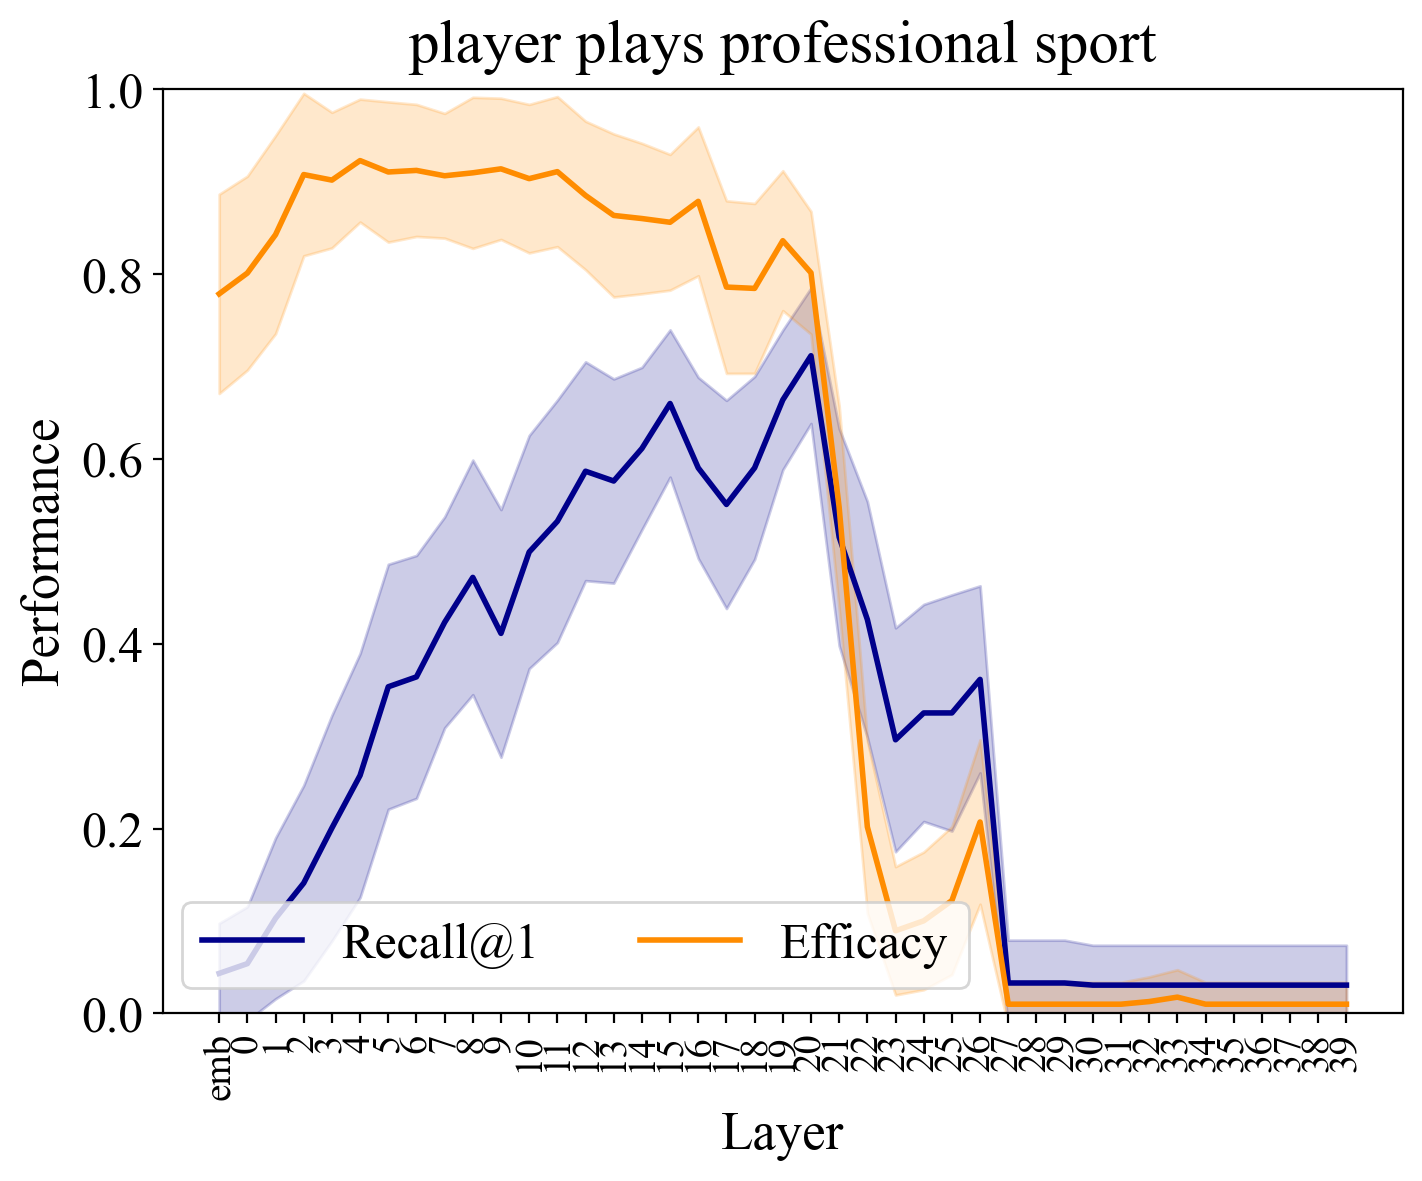

In [10]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
plot_layerwise(ax, relation_result)
plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
ax.set_ylabel("Performance")
ax.set_title("player plays professional sport", fontsize=BIGGER_SIZE, pad=10)
ax.legend(ncol = 2, bbox_to_anchor=(0.67, .0), loc='lower right')

# plt.savefig(f"{fig_dir}/{model_name}-sweep-not-bare.pdf", bbox_inches="tight")
plt.show()

In [11]:
dataset = data.load_dataset()
all_relations = [
    relation.name for relation in dataset.relations
]
all_relations = sorted(all_relations)
# all_relations
failed_relations = list(set(all_relations) - set(sweep_results.keys()))
failed_relations = sorted(failed_relations)

failed_relations

['president birth year', 'president election year']

In [12]:
# ############################################
# efficacy_root = "../../results/efficacy_baselines-24-trials"
# ############################################

# efficacy_path = f"{efficacy_root}/{model_name}"

In [13]:
# def read_efficacy_baseline_results(sweep_path):
#     efficacy_baseline_results = {}

#     for relation_folder in os.listdir(sweep_path):
#         cur_sweep = f"{sweep_path}/{relation_folder}"
#         if "results_all.json" not in os.listdir(cur_sweep):
#             continue
#         with open(f"{cur_sweep}/results_all.json") as f:
#             res = json.load(f)["relations"]
#             if(len(res) == 0 or len(res[0]["trials"]) ==  0):
#                 continue
#             res = res[0]
#             efficacy_baseline_results[res["relation_name"]] = res
#     return efficacy_baseline_results

# efficacy_baseline_results = read_efficacy_baseline_results(efficacy_path)

# print(len(efficacy_baseline_results))
# list(efficacy_baseline_results.keys())

In [14]:
# def parse_efficacy_baseline_results(efficacy_result):
#     layerwise_results = {}
#     for trial in efficacy_result["trials"]:
#         for layer in trial["layerwise_baseline_results"]:
#             layer_name = layer["layer"]
#             if layer_name not in layerwise_results:
#                 layerwise_results[layer_name] = {
#                     edit_type: [] for edit_type in layer["results"].keys()
#                 }
#                 layerwise_results[layer_name]
#             for edit_type in layer["results"].keys():
#                 layerwise_results[layer_name][edit_type].append(layer['results'][edit_type])
    
#     for layer_name in layerwise_results.keys():
#         for edit_type in layerwise_results[layer_name].keys():
#             layerwise_results[layer_name][edit_type] = AggregateMetric.aggregate(layerwise_results[layer_name][edit_type])
        
#     return {
#         "relation_name": efficacy_result["relation_name"],
#         "layerwise_result": layerwise_results
#     }


# # parse_efficacy_baseline_results(
# #     efficacy_baseline_results["country capital city"]
# # )

In [15]:
# color_dict = {
#     # "low_rank_pinv": "darkblue",
#     "hidden_baseline": "darkgreen",
#     "embed_baseline": "darkred",
#     "hidden_baseline_z": "blue"
# }

# edit_type_legends = {
#     # "low_rank_pinv": "Efficacy",
#     "hidden_baseline"   : "Replacing with s′",
#     "embed_baseline"    : "Replacing with e",
#     "hidden_baseline_z" : "Replacing with o′"
# }

# def plot_efficacy_baseline(ax, efficacy_result):
#     layerwise_result = efficacy_result["layerwise_result"]
#     layers = list(layerwise_result.keys())
#     edit_types = list(layerwise_result[layers[0]].keys())

#     for edit_type in edit_types:
#         if(edit_type not in color_dict):
#             continue
#         ax.plot(
#             range(len(layers)),
#             [layerwise_result[layer][edit_type].mean for layer in layers],
#             label=edit_type_legends[edit_type],
#             color=color_dict[edit_type],
#             alpha=0.7,
#             linestyle='--'
#         )
#         ax.fill_between(
#             range(len(layers)),
#             [layerwise_result[layer][edit_type].mean - layerwise_result[layer][edit_type].stdev for layer in layers],
#             [layerwise_result[layer][edit_type].mean + layerwise_result[layer][edit_type].stdev for layer in layers],
#             alpha=0.1,
#             color=color_dict[edit_type]
#         )
#     ax.set_xticks(range(len(layers)))
#     ax.set_xticklabels(layers)
#     ax.legend()
#     ax.set_xlabel("Layer")
#     ax.set_ylabel("Efficacy")
#     if(ax.get_title() == ""):
#         ax.set_title(efficacy_result["relation_name"])



# efficacy_result = parse_efficacy_baseline_results(
#     efficacy_baseline_results[relation]
# )

# # fig, ax = plt.subplots(figsize=(10, 5))
# # plot_efficacy_baseline(ax, efficacy_result)

In [16]:
# plt.rcdefaults()
# fig_dir = "figs"
# #####################################################################################
# plt.rcdefaults()
# plt.rcParams["figure.dpi"] = 200
# plt.rcParams["font.family"] = "Times New Roman"

# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 22

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=50)  # fontsize of the figure title
# #####################################################################################

# nrows = 1
# ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
# plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
# plot_efficacy_baseline(ax, efficacy_result)
# ax.set_ylabel("Success @ 1")
# ax.set_title(relation, fontsize=BIGGER_SIZE, pad=10)
# ax.legend(ncol = 1, bbox_to_anchor=(1, 1), loc='upper right')

# plt.savefig(f"{fig_dir}/{model_name}-causality_baselines.pdf", bbox_inches="tight")
# plt.show()

In [17]:
# ranks = {
#     layer : layer_summary.rank.values
#     for layer, layer_summary in relation_result.by_layer().items()
# }
# ranks

In [20]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in tqdm(interested_dataset.relations):
    if relation.name not in sweep_results:
        continue
    relation_result = relation_from_dict(sweep_results[relation.name])
    if len(relation_result.trials) < (3 if model_name != "llama-13b" else 2):
        print(f"skipping {relation.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation.name] = relation_result

  0%|          | 0/47 [00:00<?, ?it/s]

skipping person native language, not enough trials, : [812]


In [21]:
filtered_results["country capital city"].best_by_faithfulness()

SweepLayerSummary(layer=20, beta=AggregateMetric(mean=2.7962962962962963, stdev=0.6010678654487956, stderr=0.1156755646393653, values=[4.25, 2.75, 3.0, 2.25, 2.75, 2.75, 3.0, 2.25, 2.0, 2.0, 3.25, 2.25, 2.75, 2.5, 3.0, 1.75, 3.0, 4.0, 2.75, 3.0, 4.0, 2.75, 2.75, 2.0, 3.0, 3.25, 2.5]), recall=AggregateMetric(mean=0.7116819908486576, stdev=0.07340087543284857, stderr=0.014126005063303103, values=[0.6428571428571429, 0.7333333333333333, 0.8, 0.6, 0.6923076923076923, 0.7272727272727273, 0.6666666666666666, 0.8, 0.7142857142857143, 0.6666666666666666, 0.6666666666666666, 0.6, 0.8125, 0.6428571428571429, 0.5333333333333333, 0.8, 0.6875, 0.7333333333333333, 0.6875, 0.6875, 0.7333333333333333, 0.6875, 0.75, 0.7333333333333333, 0.8666666666666667, 0.8, 0.75]), rank=AggregateMetric(mean=87.4074074074074, stdev=22.514619545496735, stderr=4.33294055176485, values=[104, 80, 104, 88, 72, 96, 96, 64, 56, 128, 96, 40, 120, 80, 64, 88, 80, 80, 128, 80, 80, 128, 64, 112, 72, 64, 96]), efficacy=Aggregate

## Sweep Figures

0 characteristic gender
1 univ degree gender
2 name birthplace
3 name gender
4 name religion


/tmp/ipykernel_1418779/3580476089.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5 occupation age
6 occupation gender
7 fruit inside color
8 fruit outside color
9 object superclass
10 substance phase of matter
11 task person type
12 task done by tool
13 word sentiment
14 work location
15 city in country
16 company CEO
17 company hq
18 country capital city
19 country currency
20 country language
21 country largest city
22 food from country
23 landmark in country
24 landmark on continent
25 person lead singer of band
26 person father
27 person mother
28 person occupation
29 person plays instrument
30 person sport position
31 plays pro sport
32 person university
33 pokemon evolution
34 product by company
35 star constellation name
36 superhero archnemesis
37 superhero person
38 adjective antonym
39 adjective comparative
40 adjective superlative
41 verb past tense
42 word first letter
43 word last letter


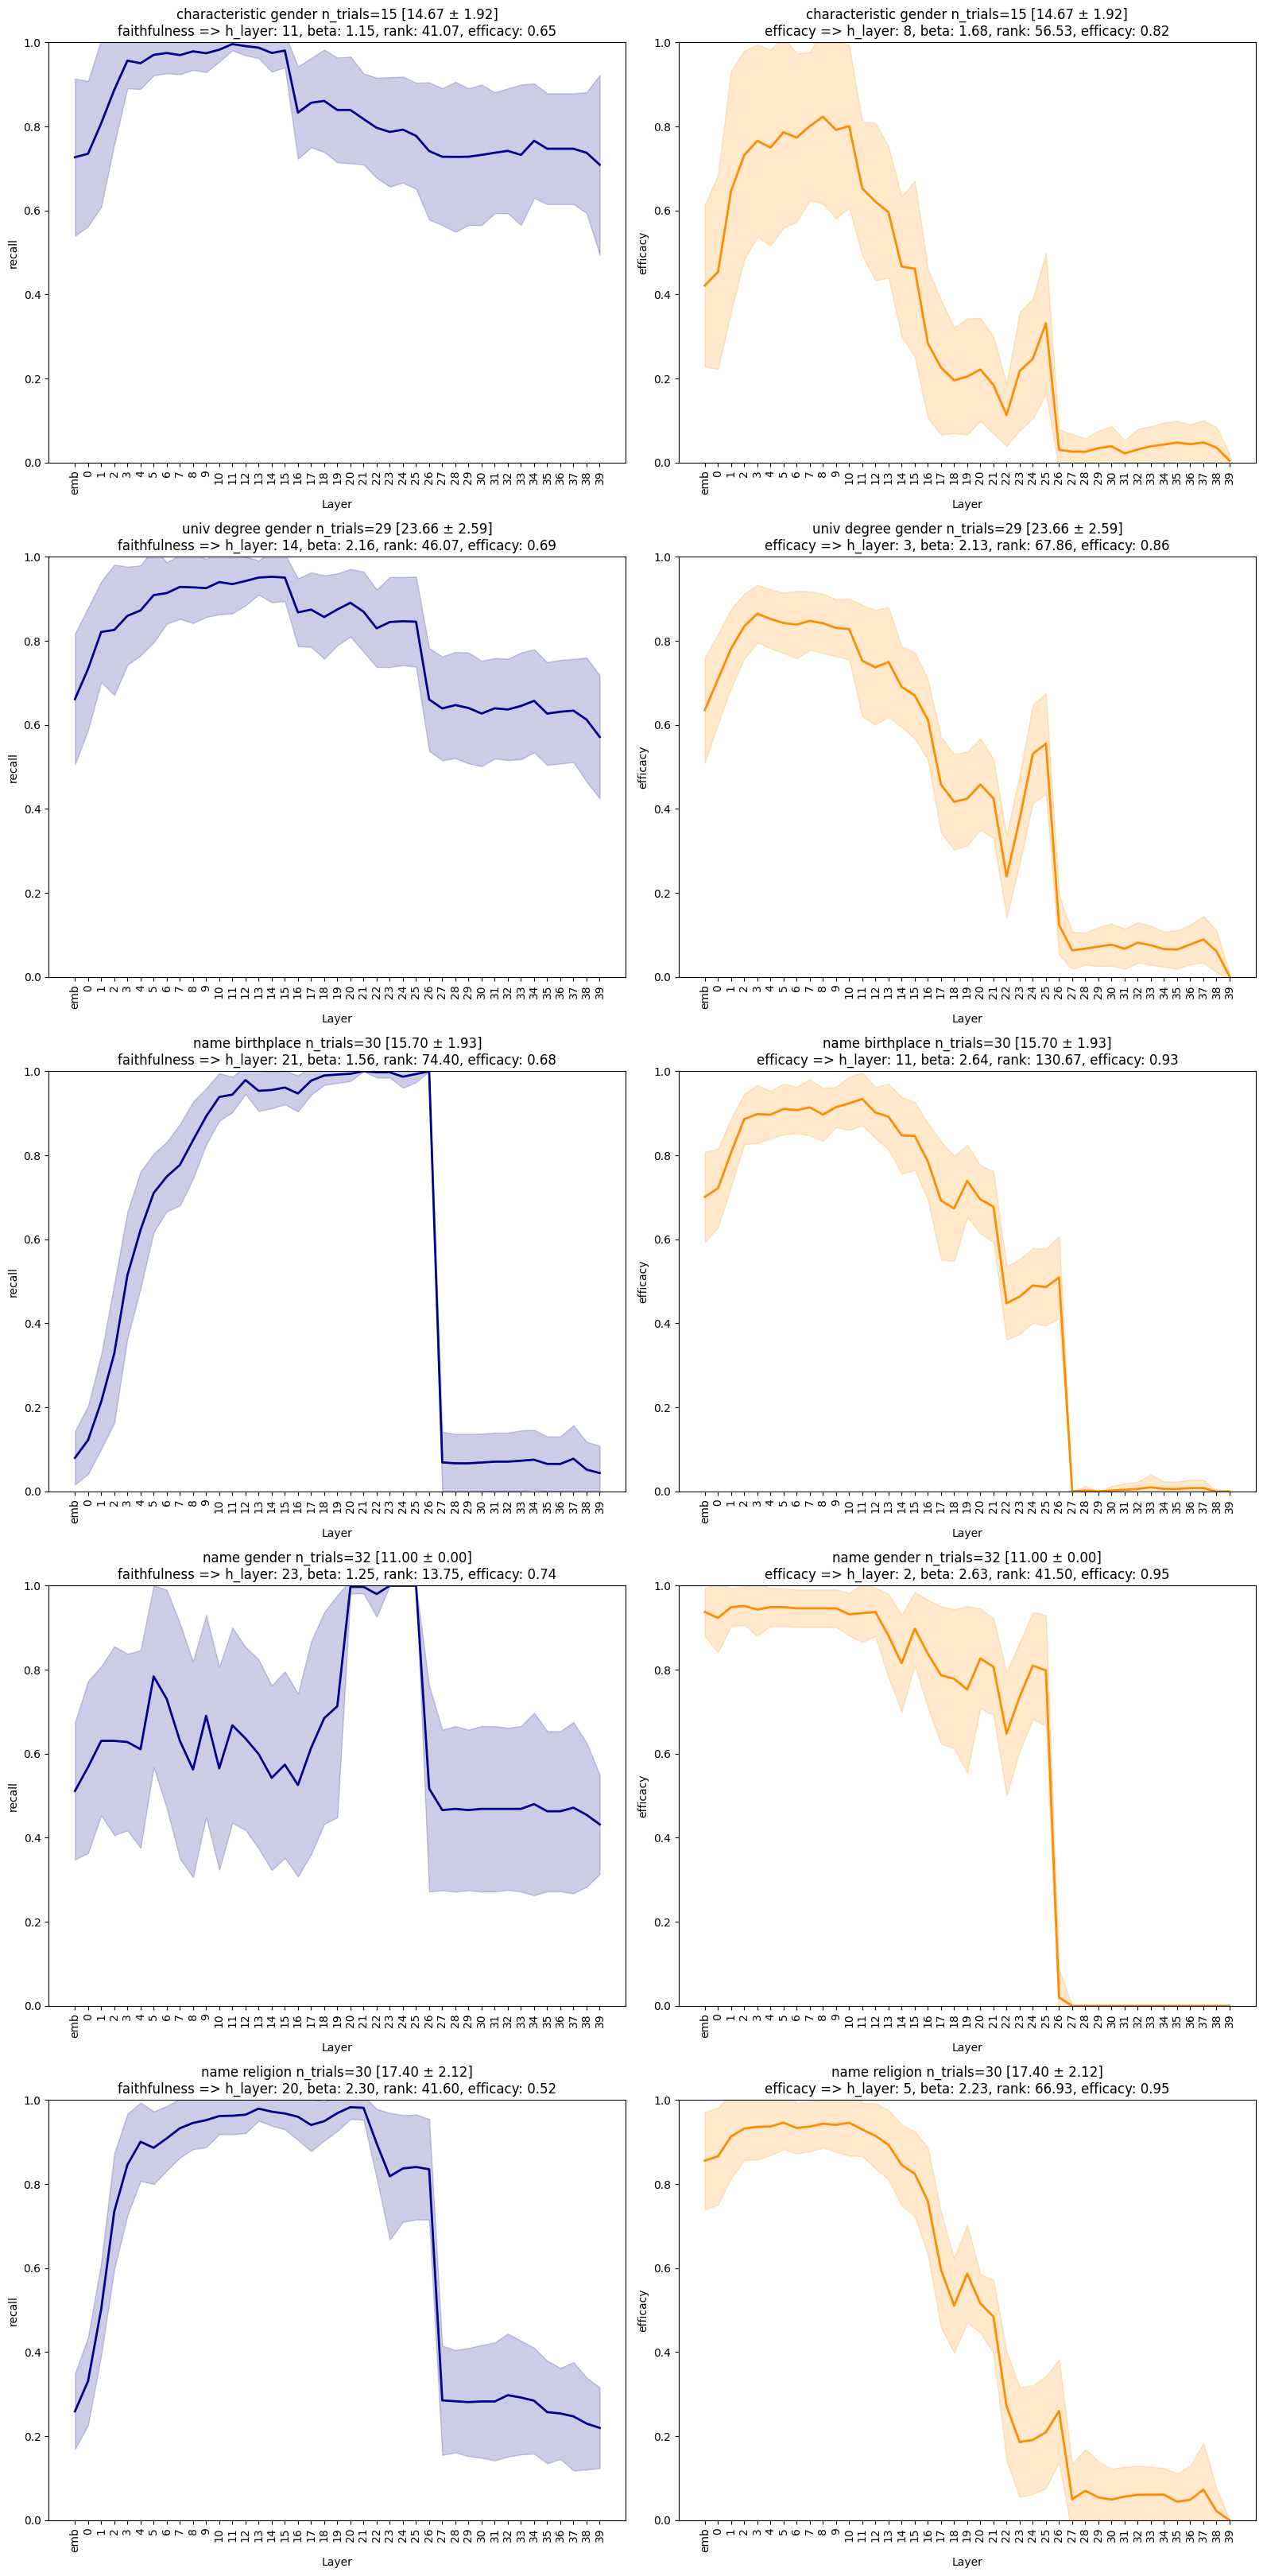

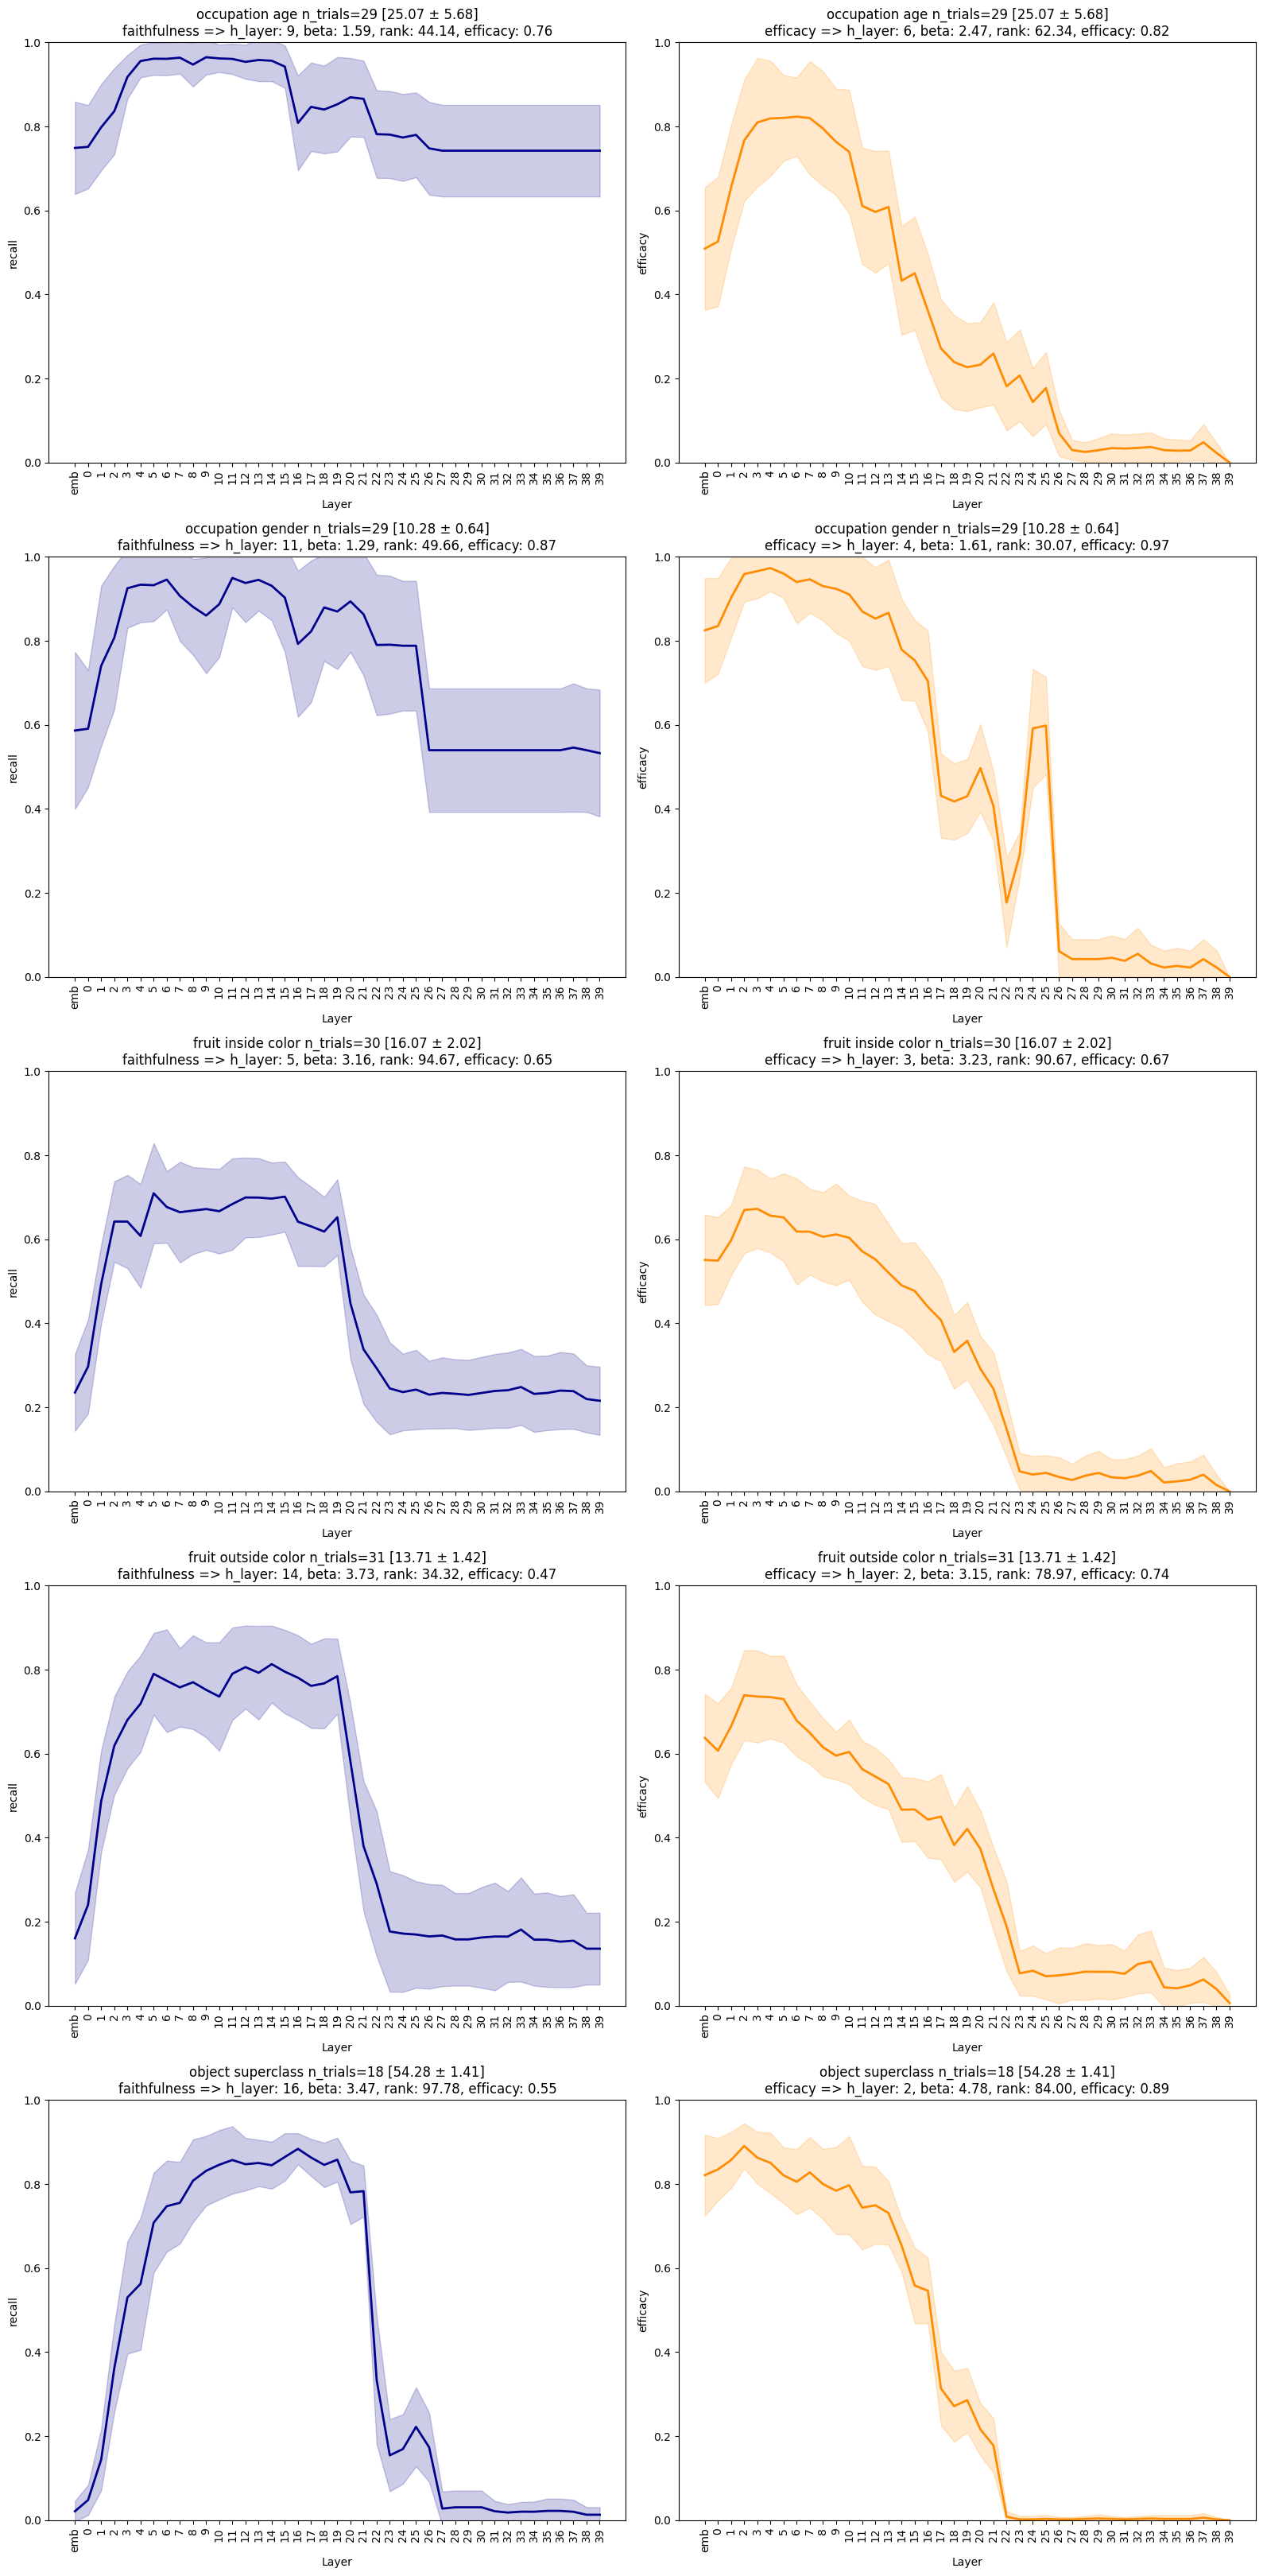

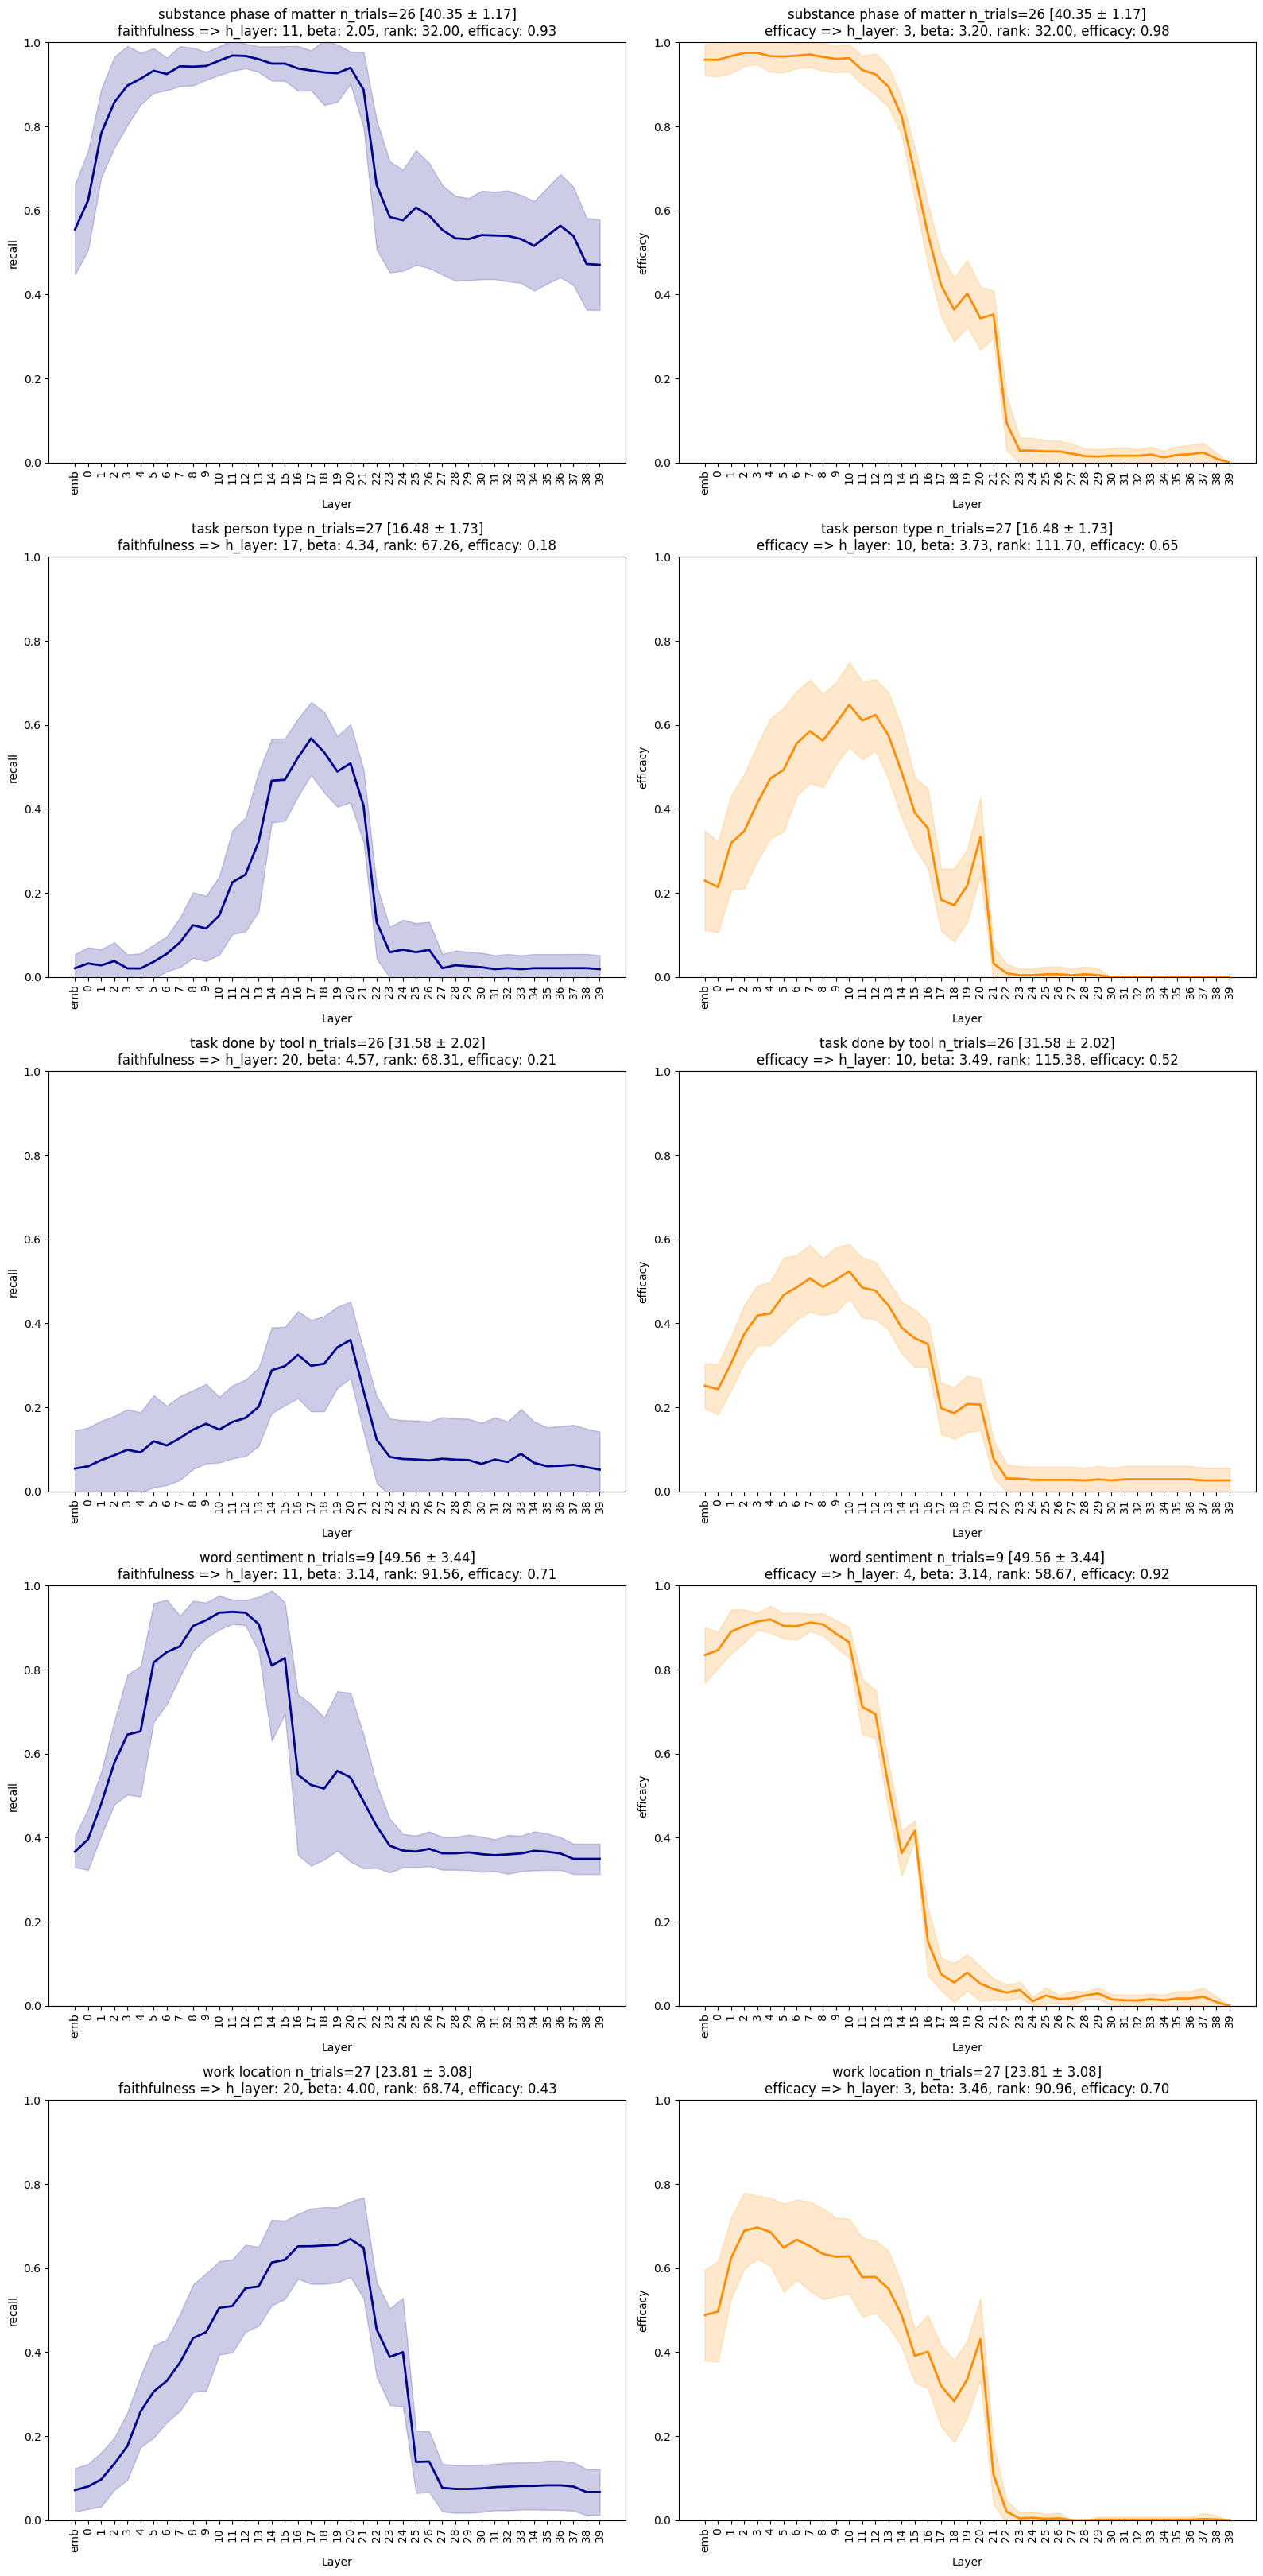

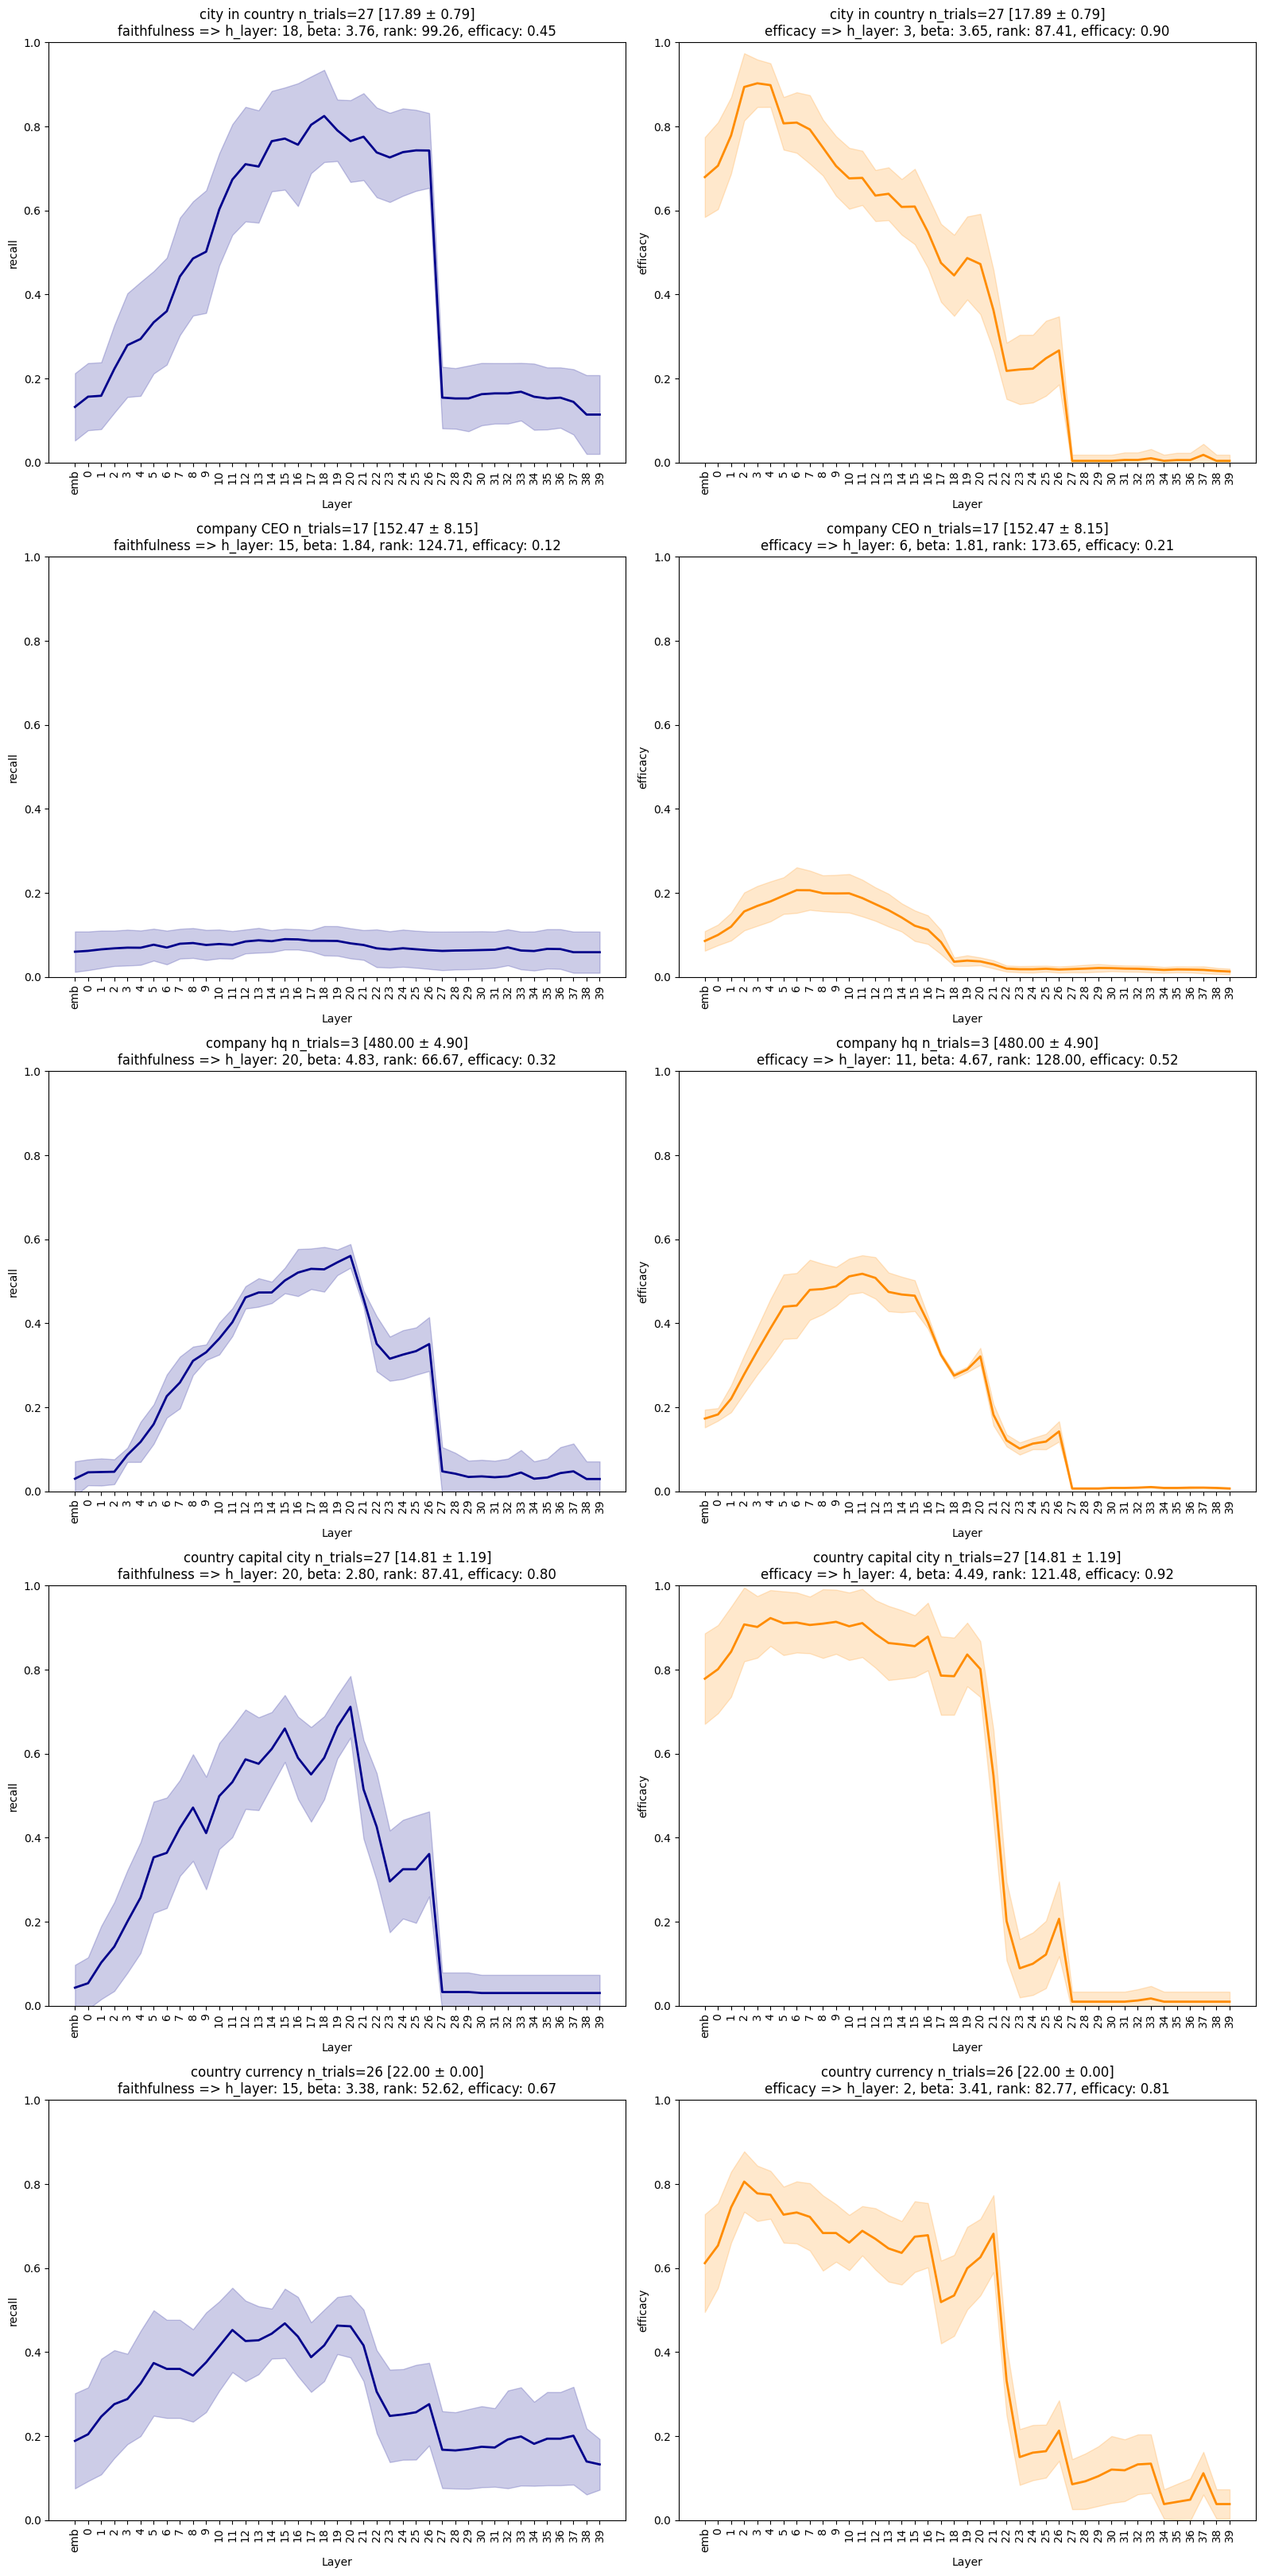

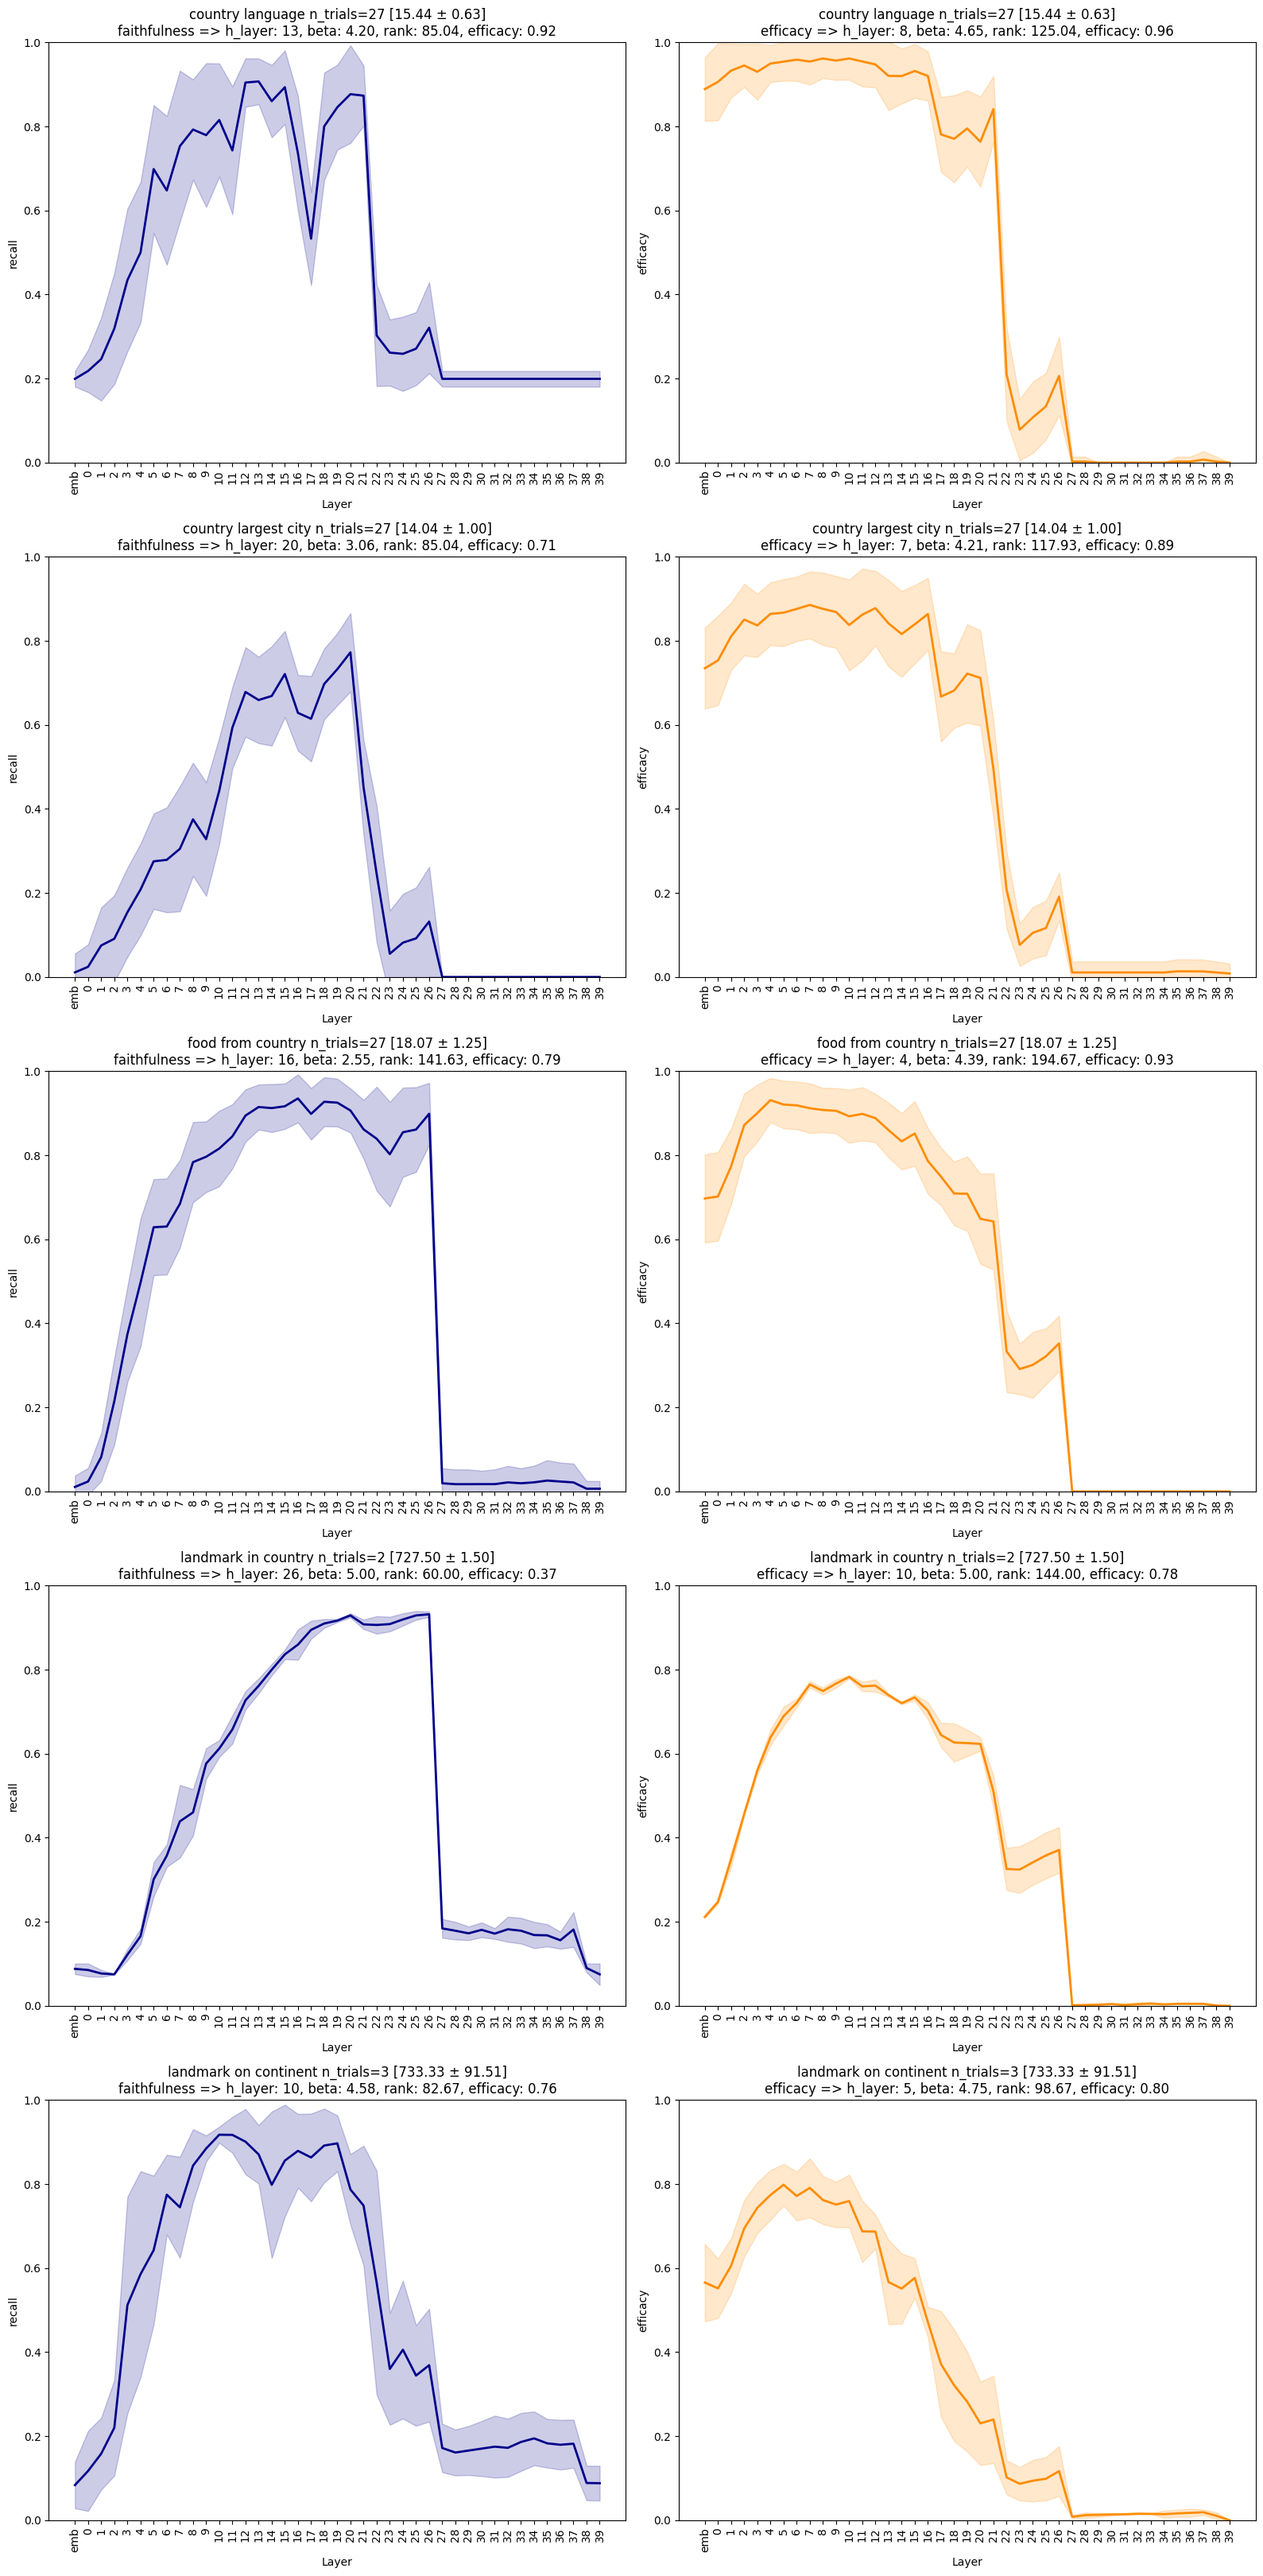

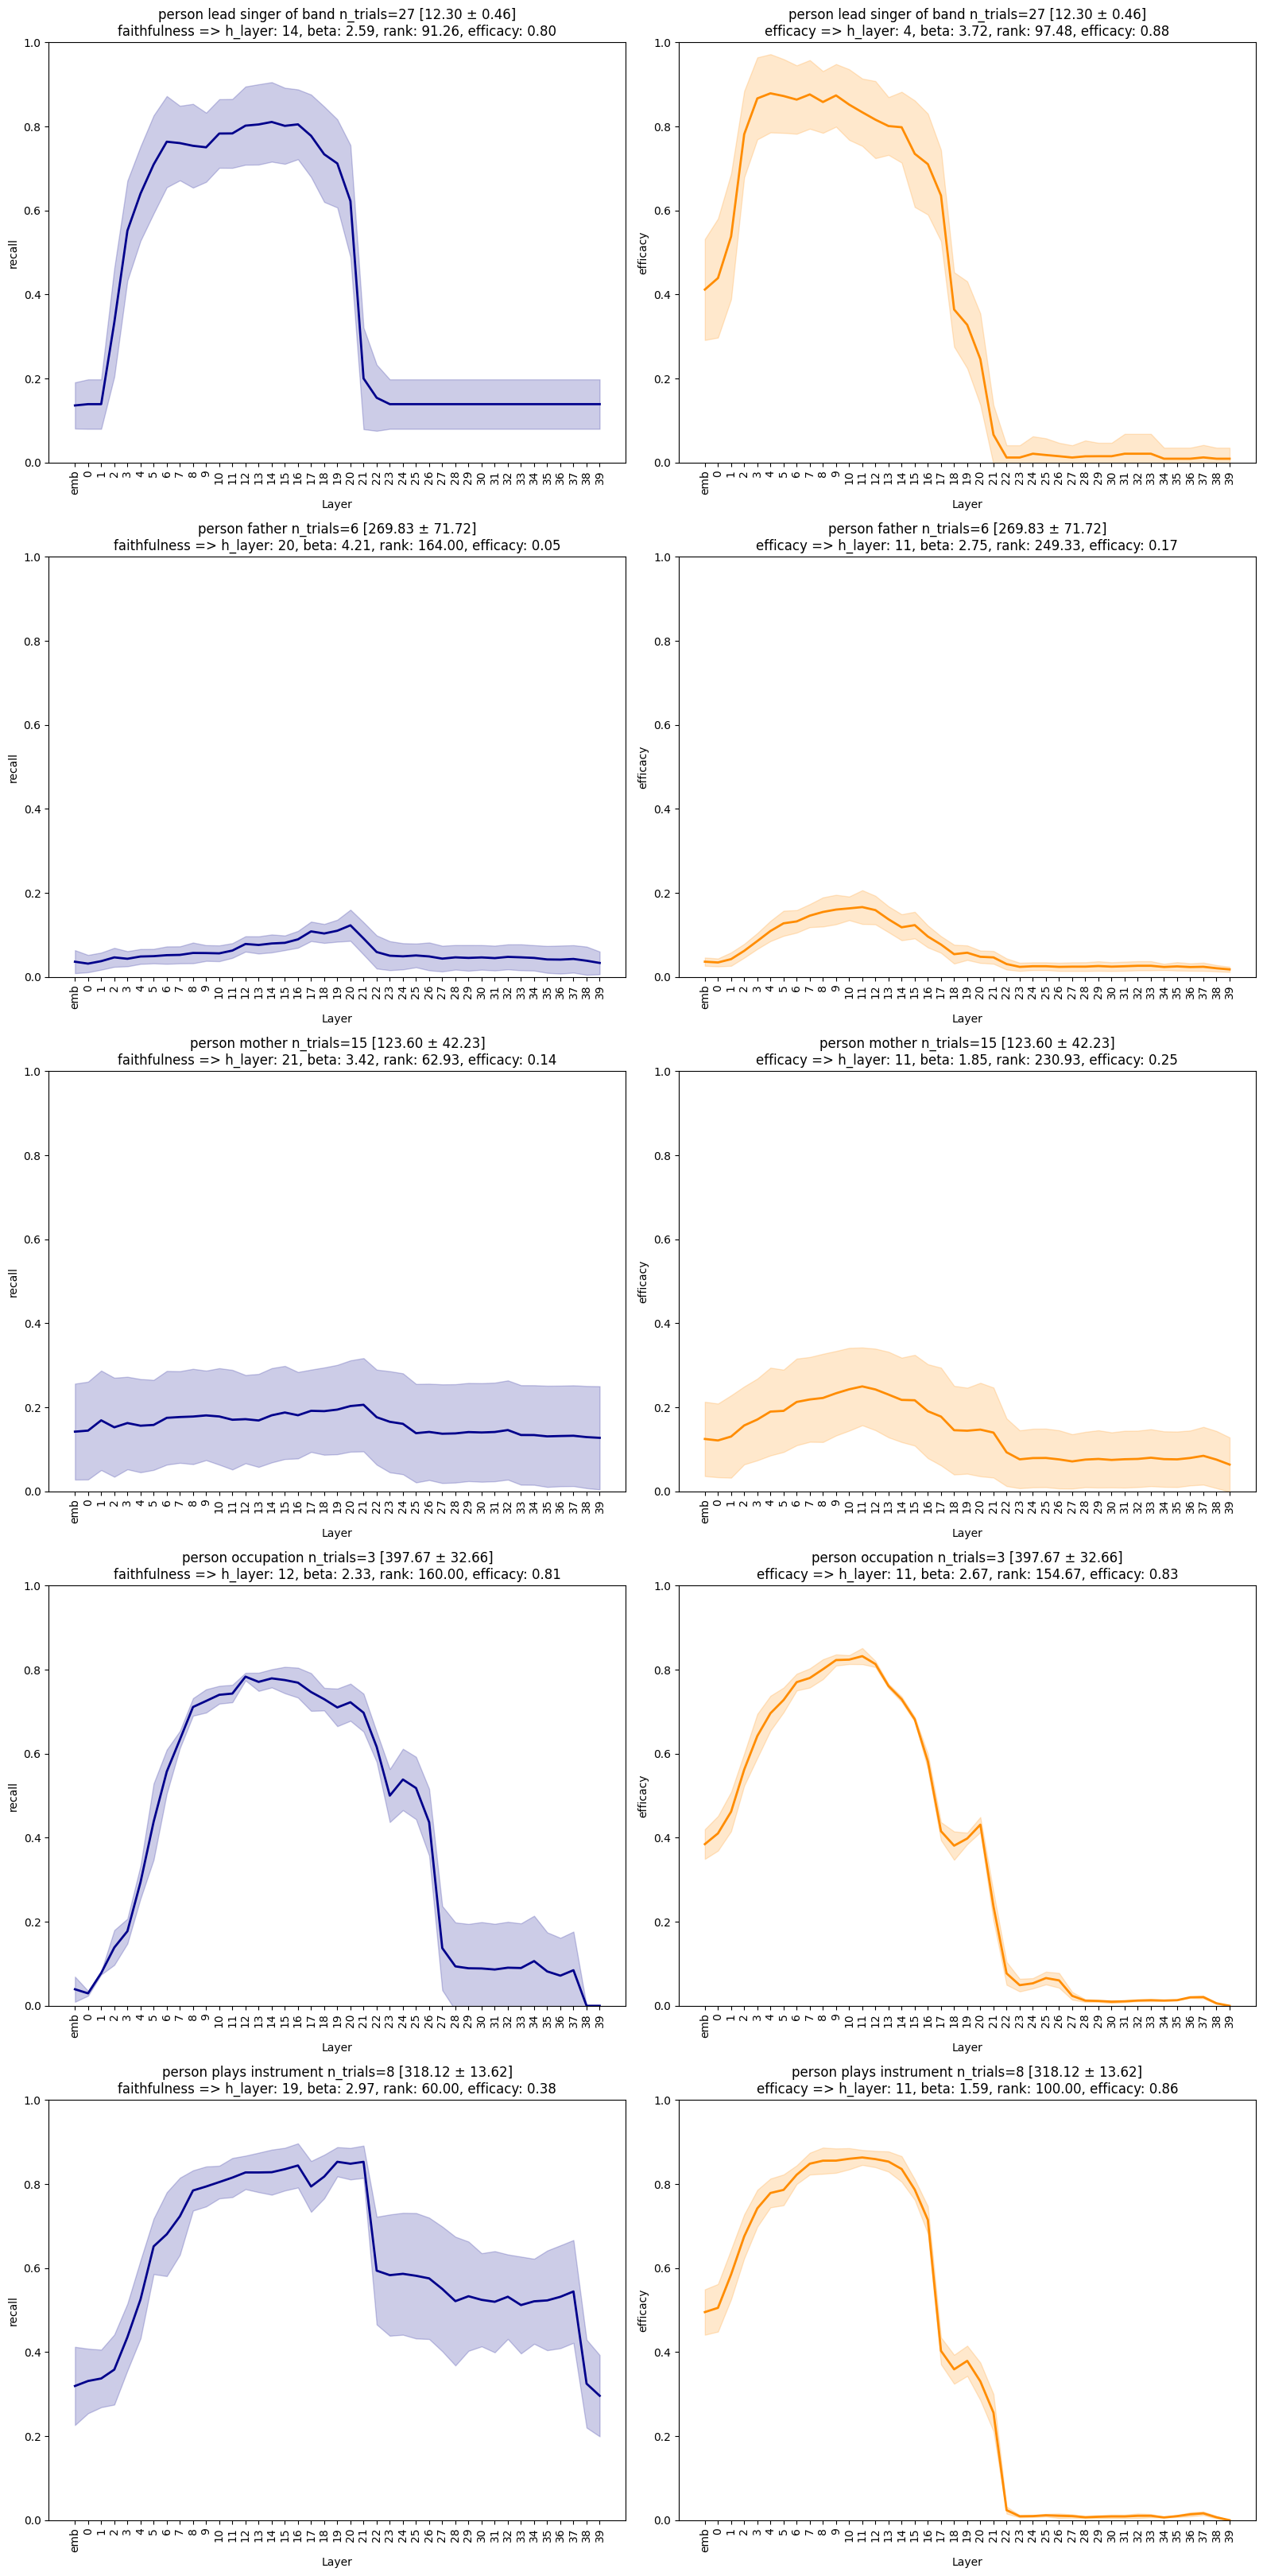

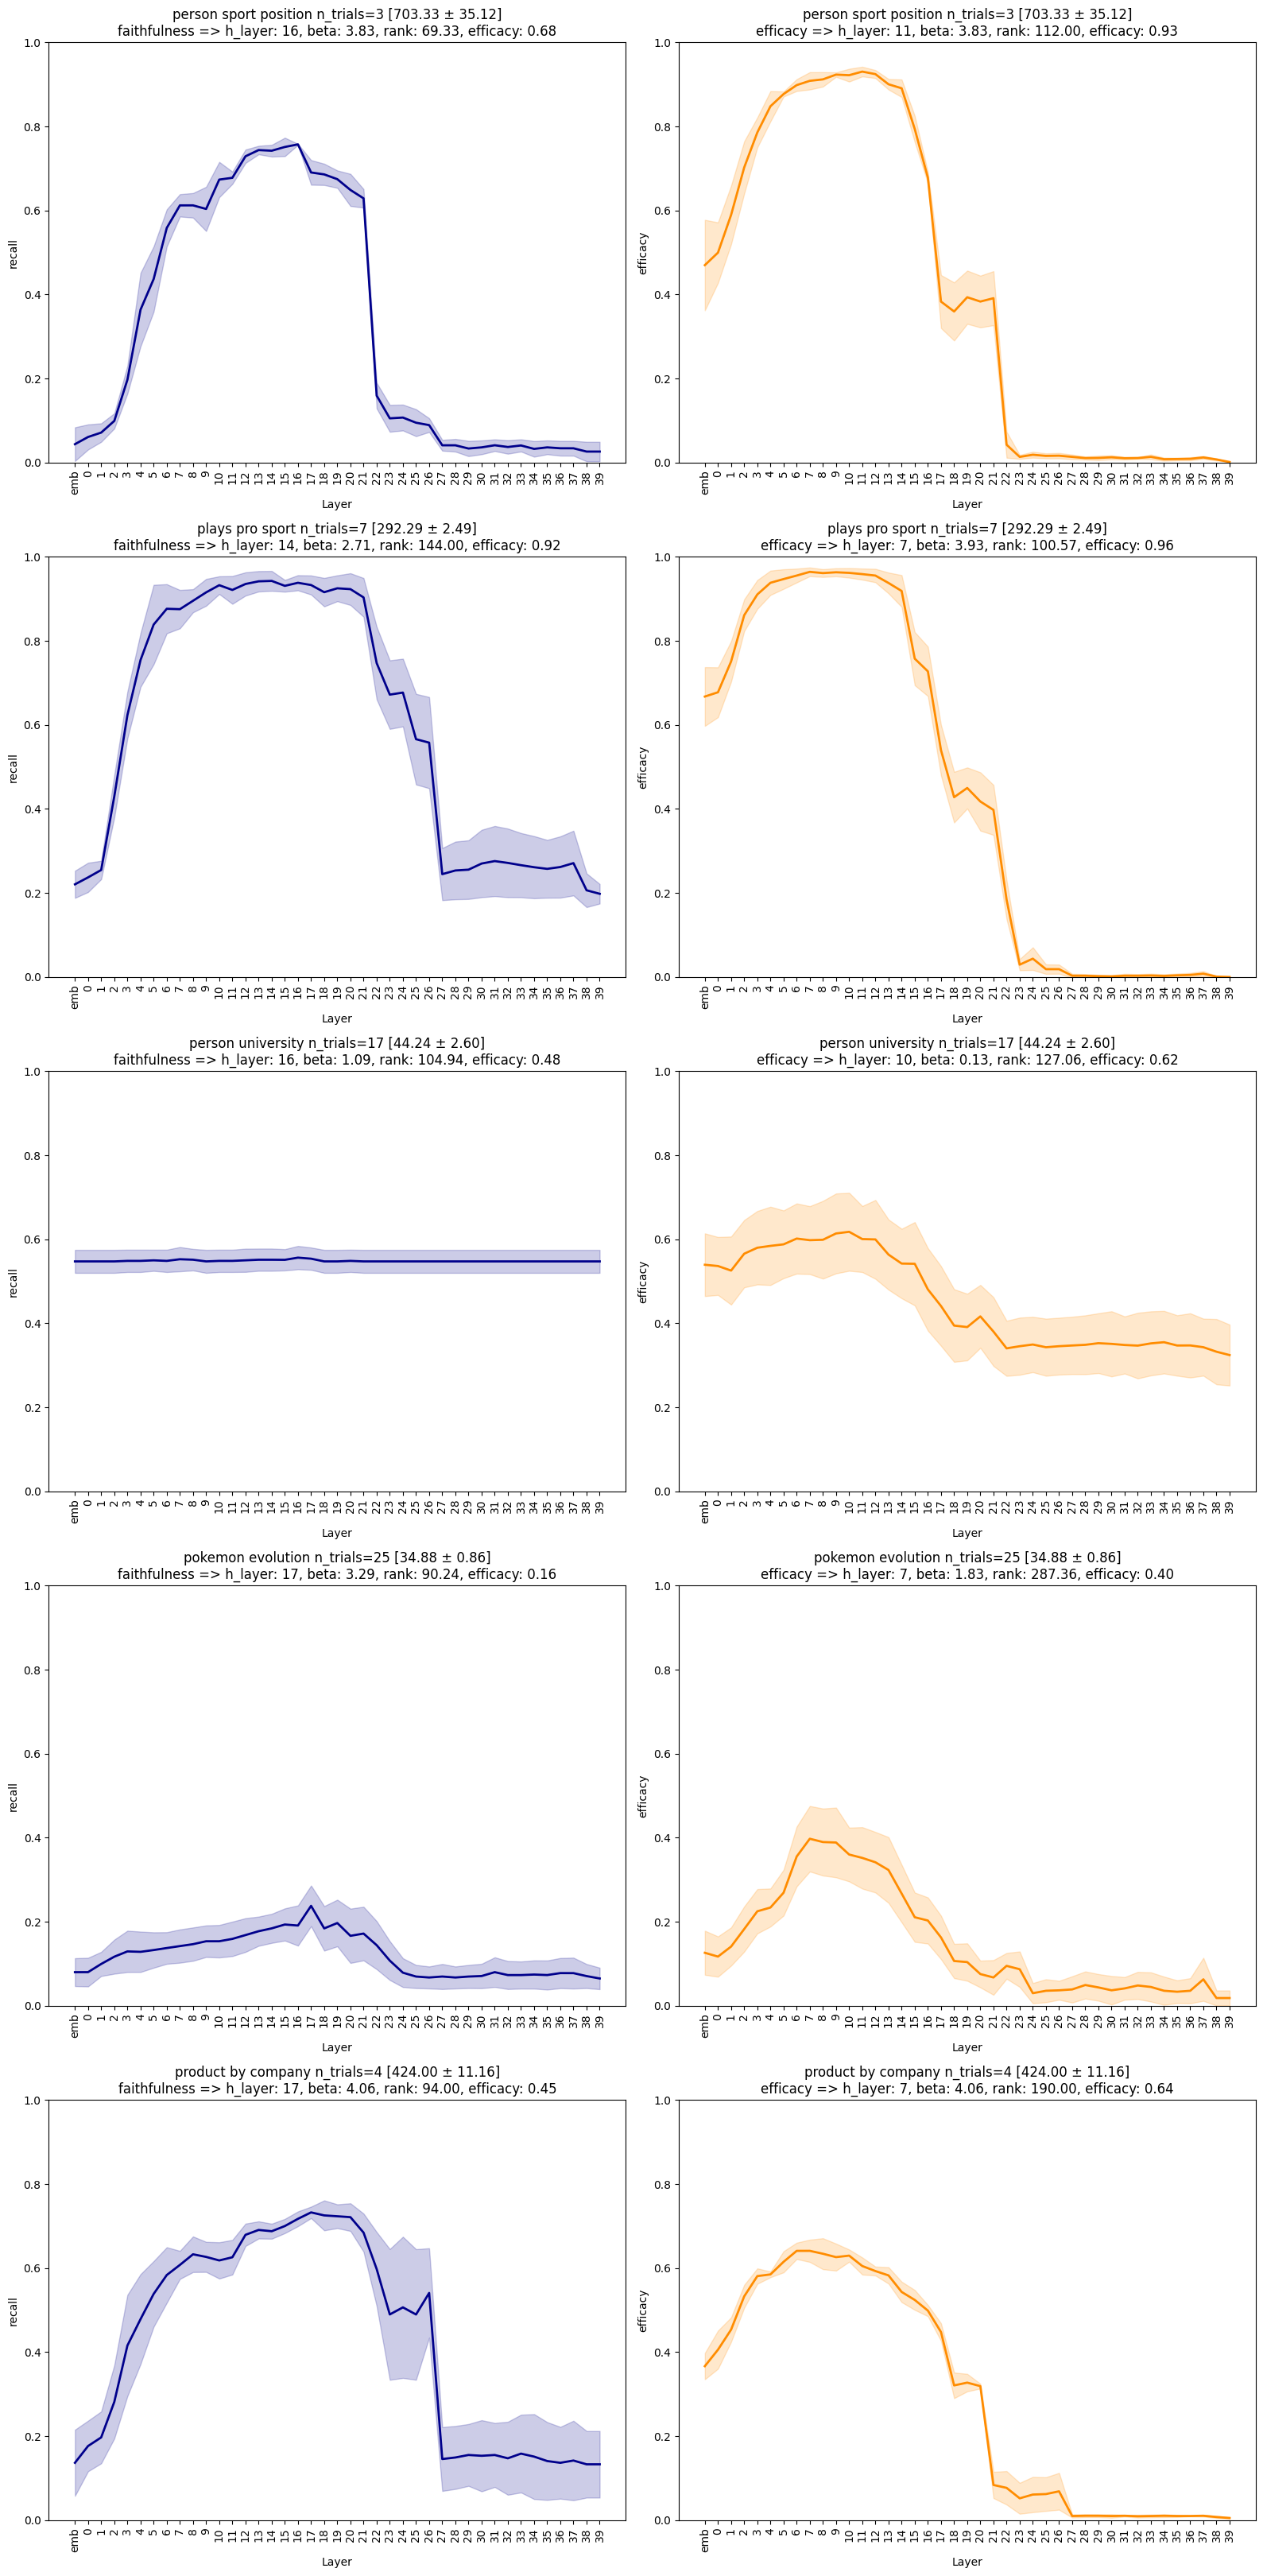

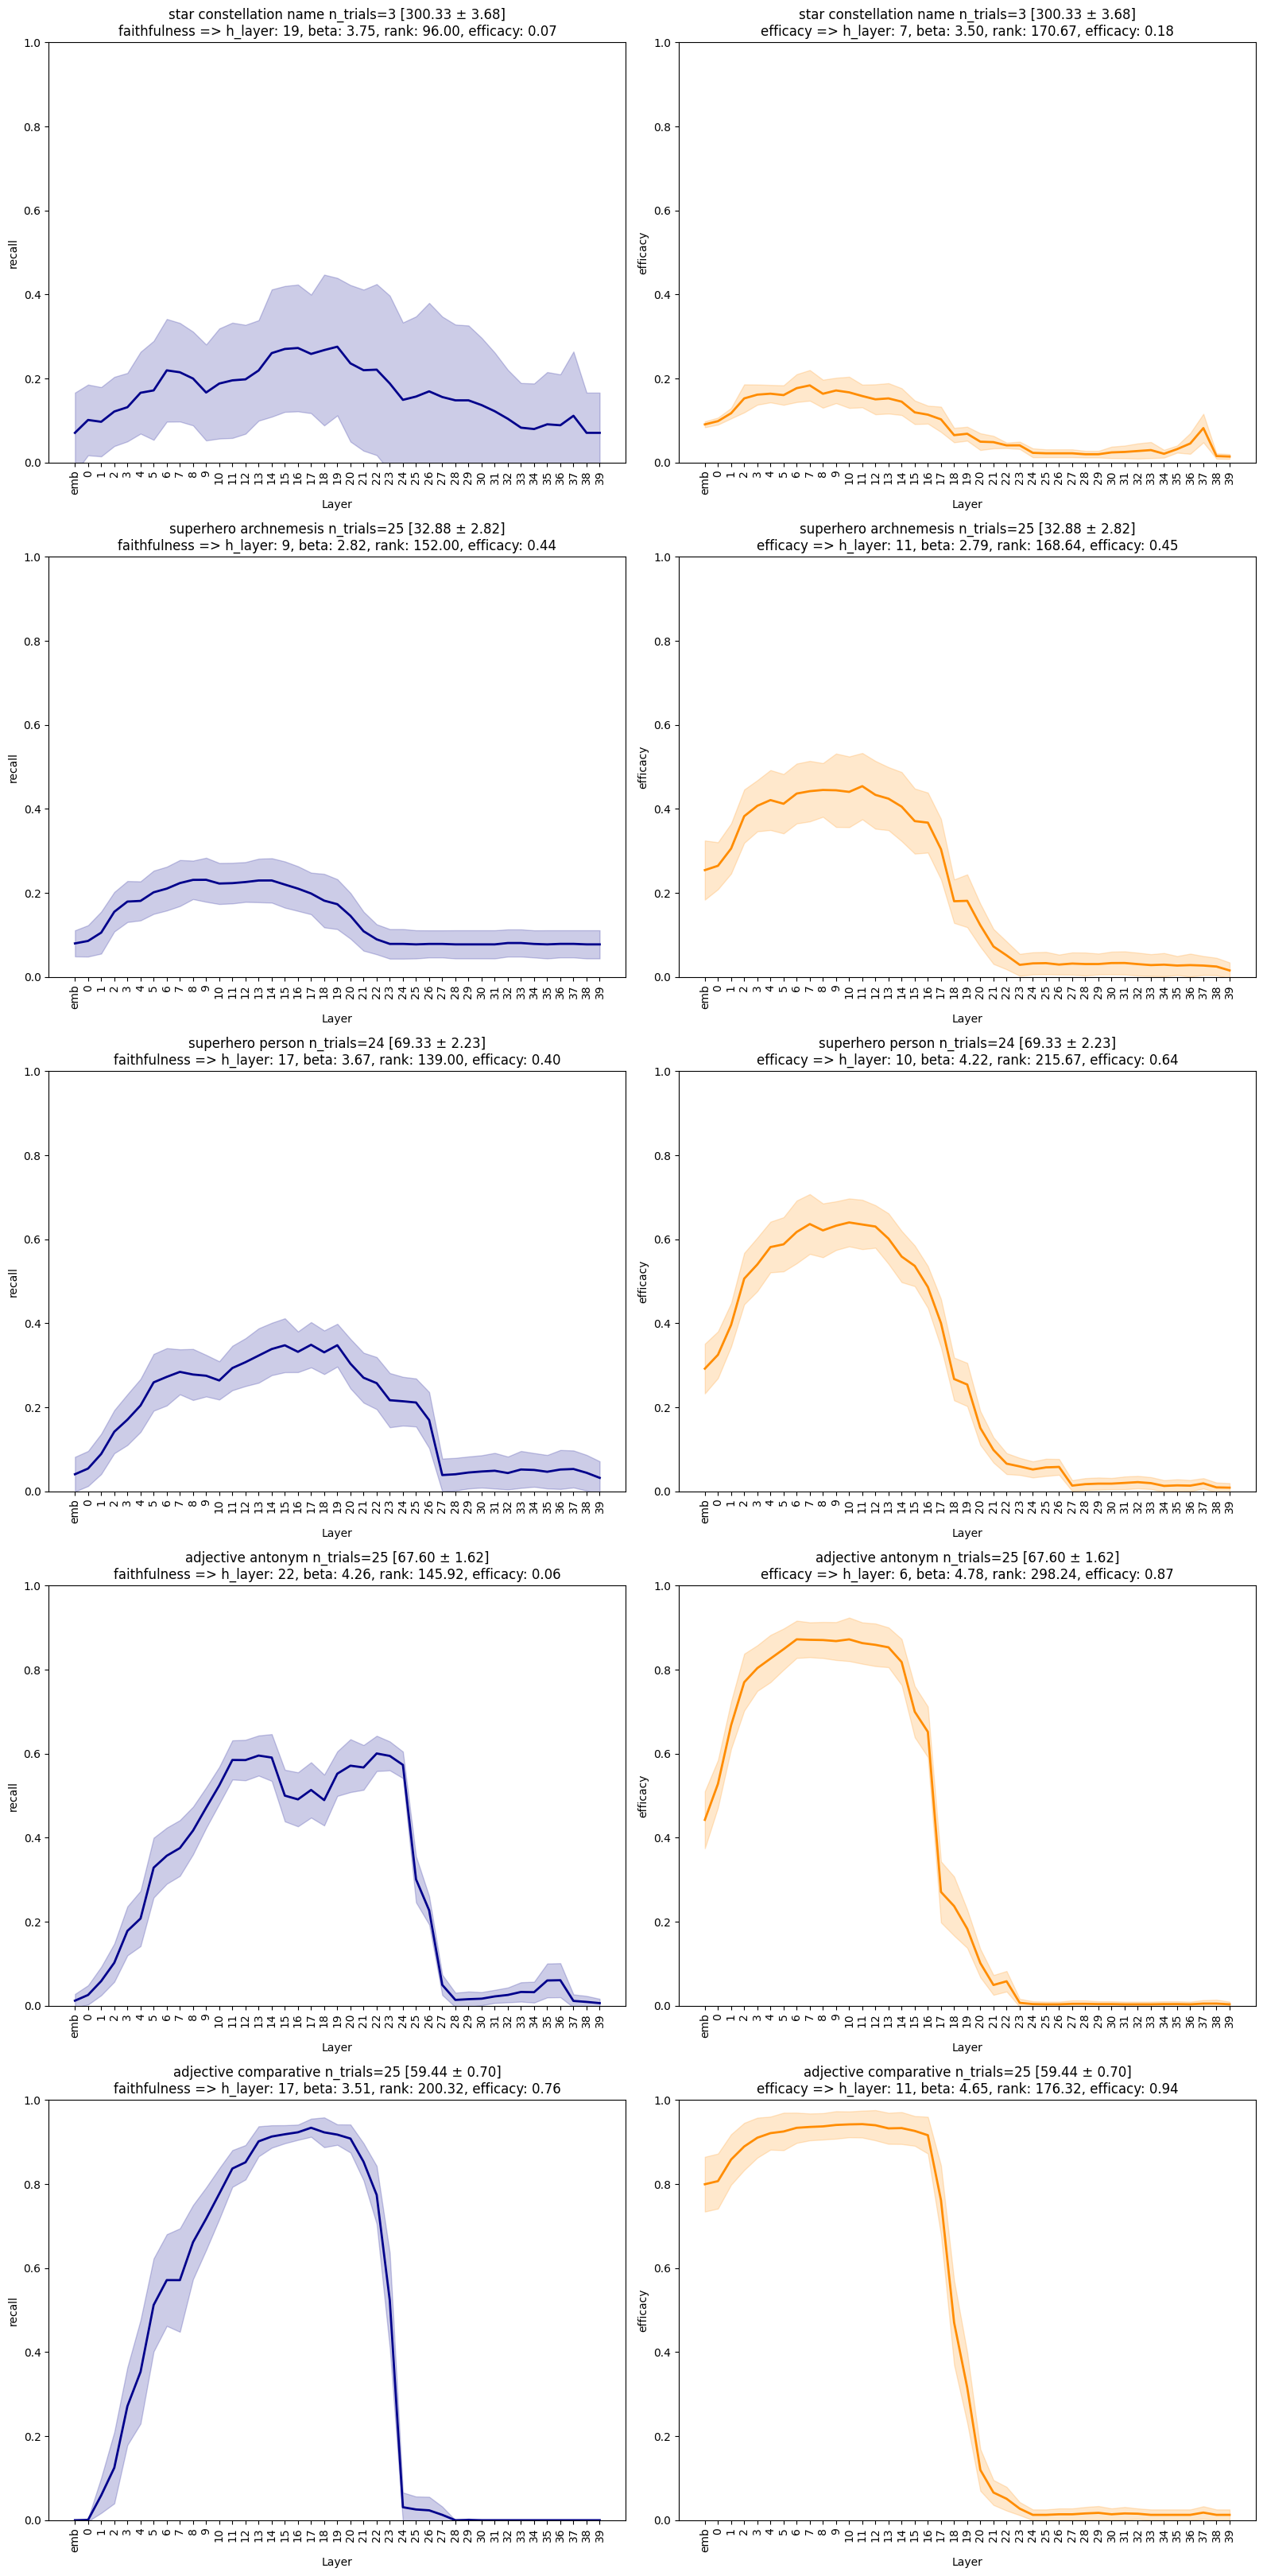

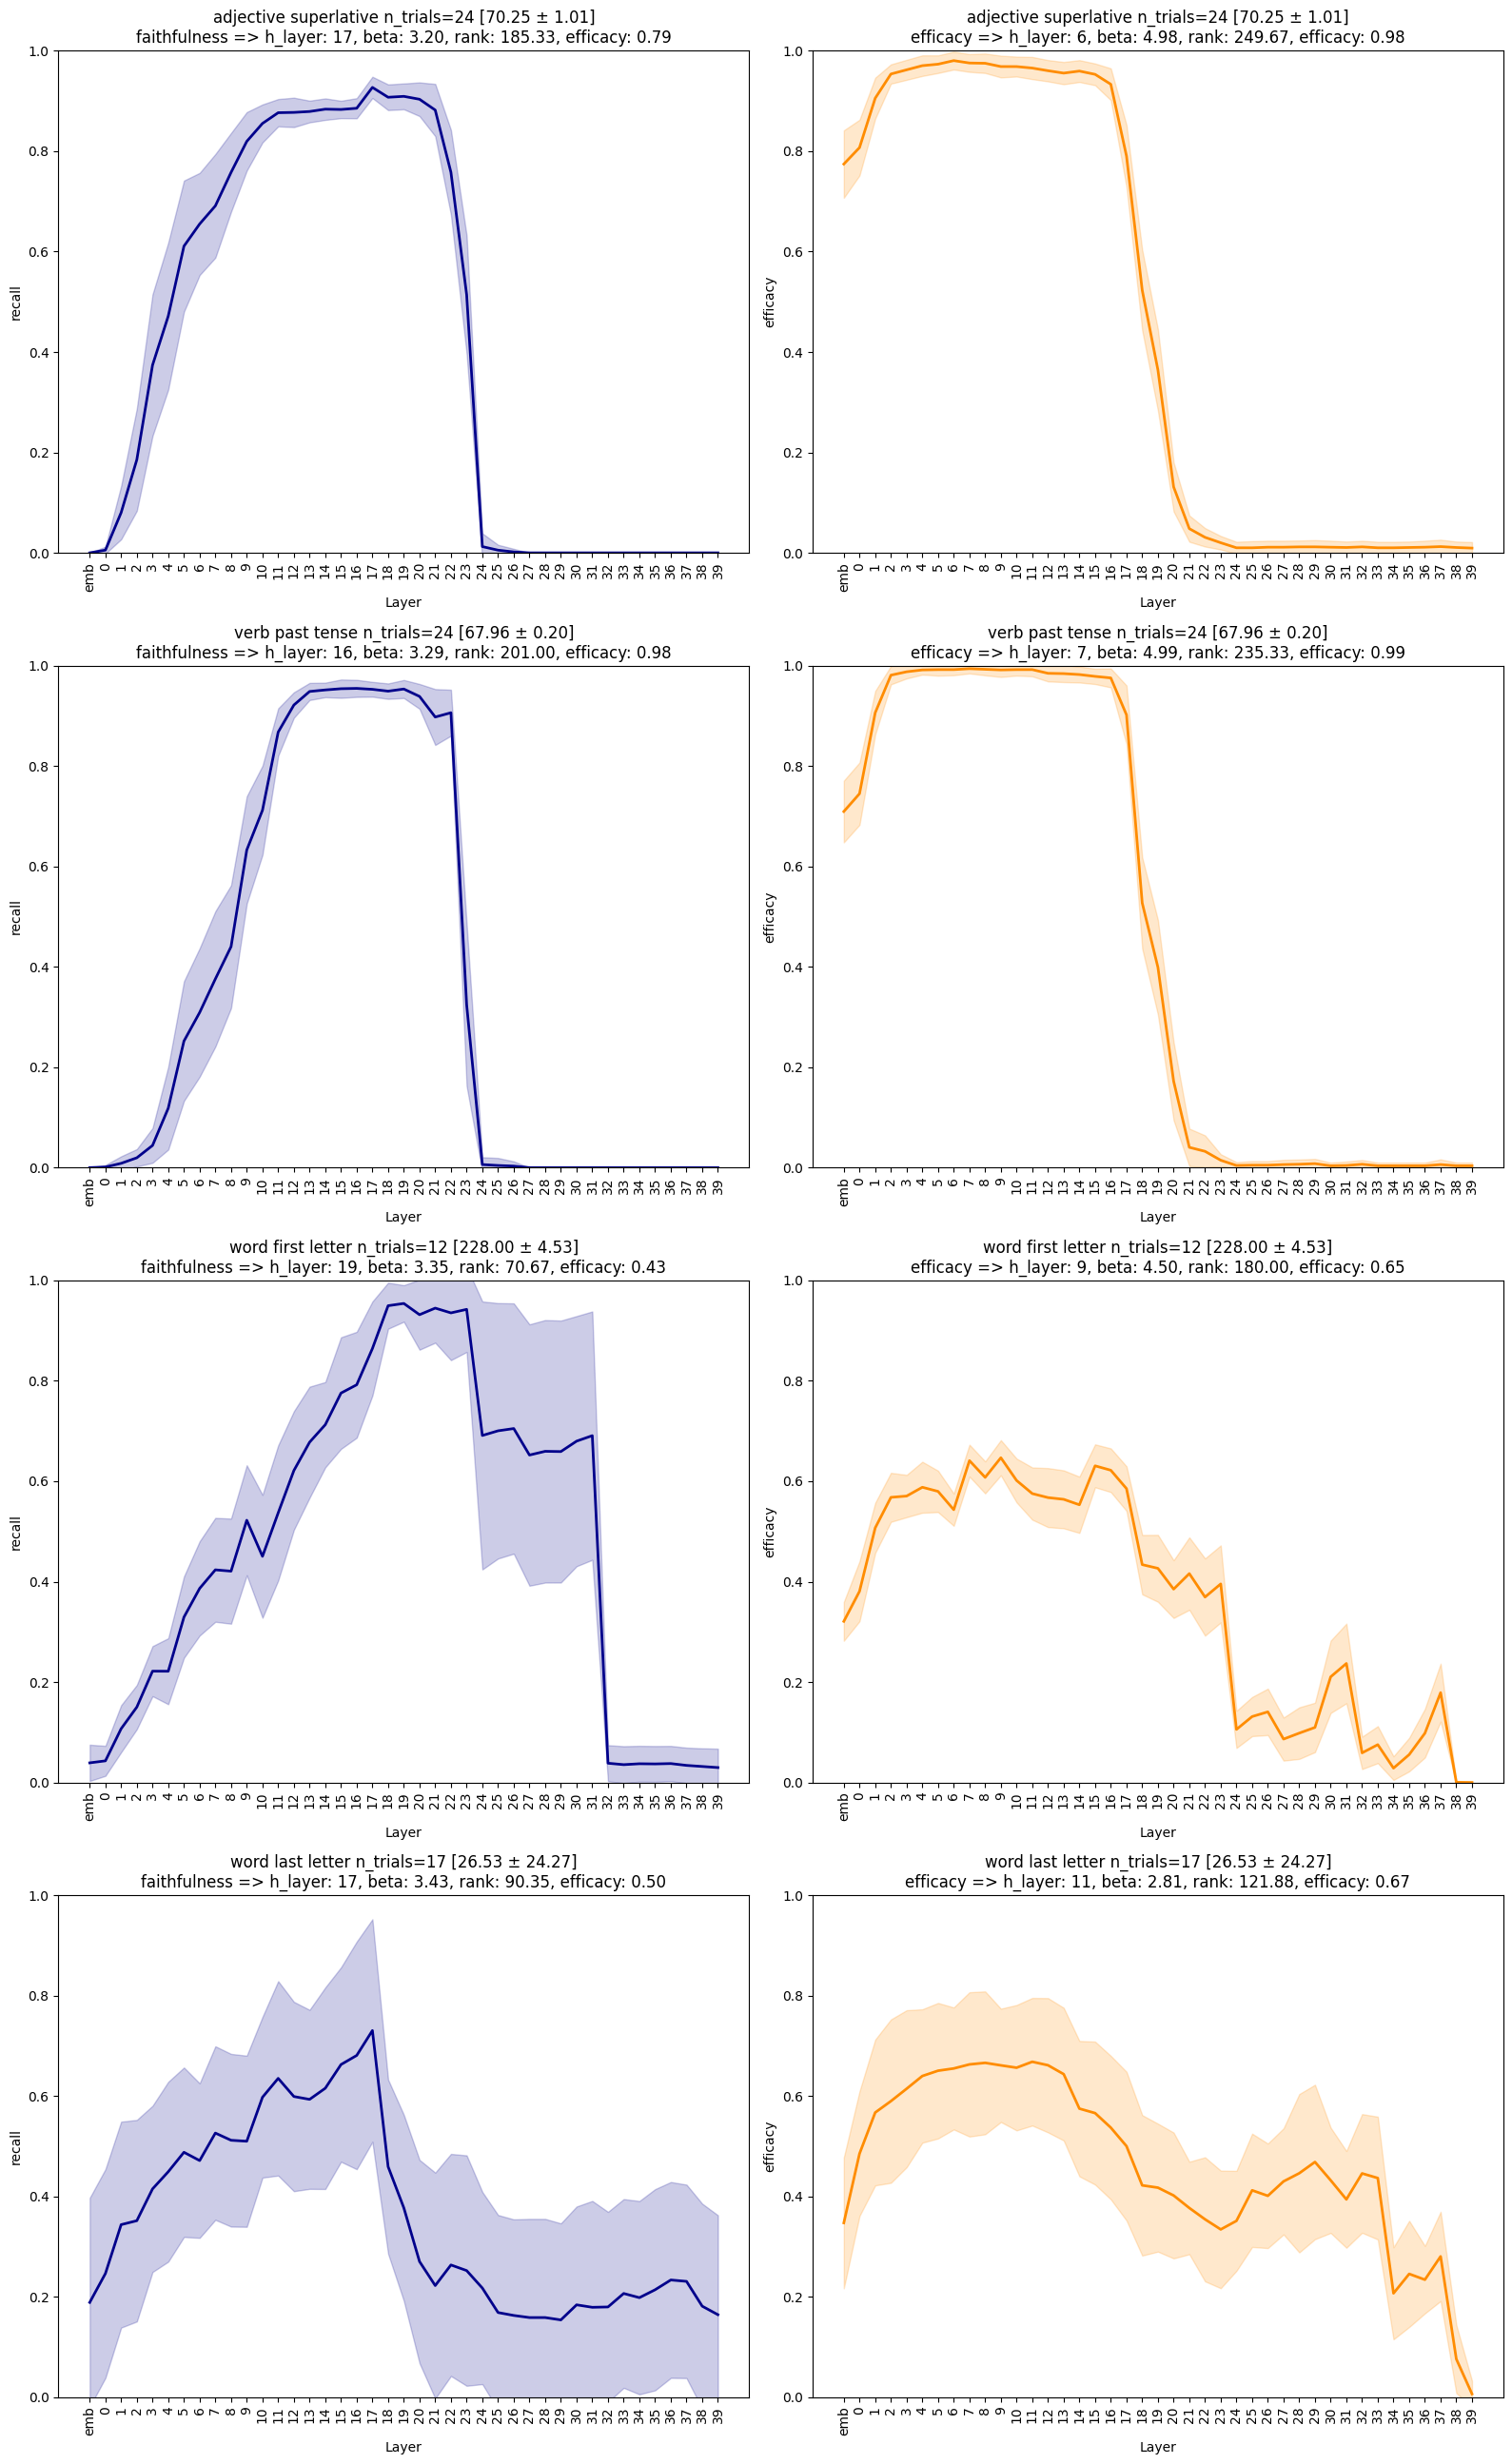

In [22]:
plt.rcdefaults()

step_size = 5

for _from in range(0, len(filtered_results), step_size):
    _to = min(len(filtered_results), _from + step_size)
    n_subplots = len(filtered_results) * 3
    n_subplots = (_to - _from)  * 2
    ncols=2
    nrows=int(np.ceil(n_subplots/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
    if n_subplots == 1:
        axes = [axes]
    if nrows == 1:
        axes = [axes]

    ax_col, ax_row = 0, 0
    for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
        print(i, relation_name)
        # result = parse_results(sweep_results[relation_name])
        result = filtered_results[relation_name]
        plot_layerwise(axes[ax_row][0], result)
        plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
        # if(relation_name in efficacy_baseline_results):
        #     efficacy_baselines = parse_efficacy_baseline_results(efficacy_baseline_results[relation_name])
        #     plot_efficacy_baseline(axes[ax_row][1], efficacy_baselines)
        ax_row += 1

    fig.tight_layout()
    fig.show()

## Causality vs Faithfulness Scatter Plots

In [23]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30, beta = None):
    recalls = []
    efficacies = []
    pass_threshold = []
    labels = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness(beta = beta).recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy(beta = beta).recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)
        labels.append(relation_name)

    return recalls, efficacies, pass_threshold, labels

/tmp/ipykernel_1418779/513232137.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


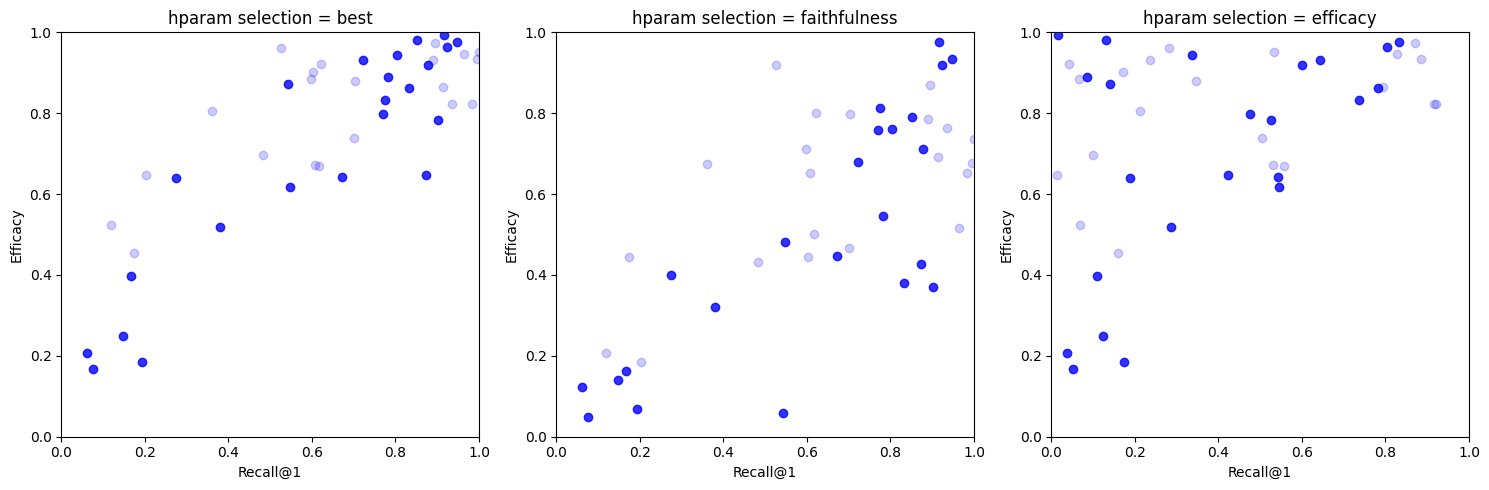

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
        filtered_results, criterion=criterion, 
        beta = 2.25
    )
    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        ax.scatter(recall, efficacy, color="blue", alpha=alpha)
        # if threshold and (recall/efficacy < .7 or efficacy/recall < .7):
        #     ax.annotate(relation_name, (recall, efficacy))


    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [25]:
from sklearn.linear_model import LinearRegression
import torch

def get_linear_model(recalls: list[float], efficacies: list[float]):
    X = torch.Tensor(recalls)[None].T
    y = torch.Tensor(efficacies)[None].T
    lm = LinearRegression().fit(X = X, y = y)
    slope = torch.Tensor(lm.coef_).squeeze().item()
    y_intercept = torch.Tensor(lm.intercept_).squeeze().item()
    r_squared = lm.score(X, y)
    return slope, y_intercept, r_squared

In [26]:
beta_options = [beta.beta for beta in relation_result.trials[0].layers[0].result.betas]

beta=0.0 | r_squared=0.05, slope=0.243, y_intercept=0.710
beta=0.25 | r_squared=0.06, slope=0.268, y_intercept=0.698
beta=0.5 | r_squared=0.09, slope=0.287, y_intercept=0.685
beta=0.75 | r_squared=0.11, slope=0.293, y_intercept=0.674
beta=1.0 | r_squared=0.12, slope=0.293, y_intercept=0.664
beta=1.25 | r_squared=0.13, slope=0.289, y_intercept=0.657
beta=1.5 | r_squared=0.14, slope=0.290, y_intercept=0.650
beta=1.75 | r_squared=0.15, slope=0.297, y_intercept=0.642
beta=2.0 | r_squared=0.16, slope=0.310, y_intercept=0.631
beta=2.25 | r_squared=0.18, slope=0.328, y_intercept=0.619
beta=2.5 | r_squared=0.20, slope=0.348, y_intercept=0.606
beta=2.75 | r_squared=0.23, slope=0.373, y_intercept=0.591
beta=3.0 | r_squared=0.25, slope=0.397, y_intercept=0.576
beta=3.25 | r_squared=0.28, slope=0.421, y_intercept=0.561
beta=3.5 | r_squared=0.31, slope=0.445, y_intercept=0.546
beta=3.75 | r_squared=0.34, slope=0.473, y_intercept=0.528
beta=4.0 | r_squared=0.37, slope=0.495, y_intercept=0.515
beta=4

/tmp/ipykernel_1418779/561082002.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


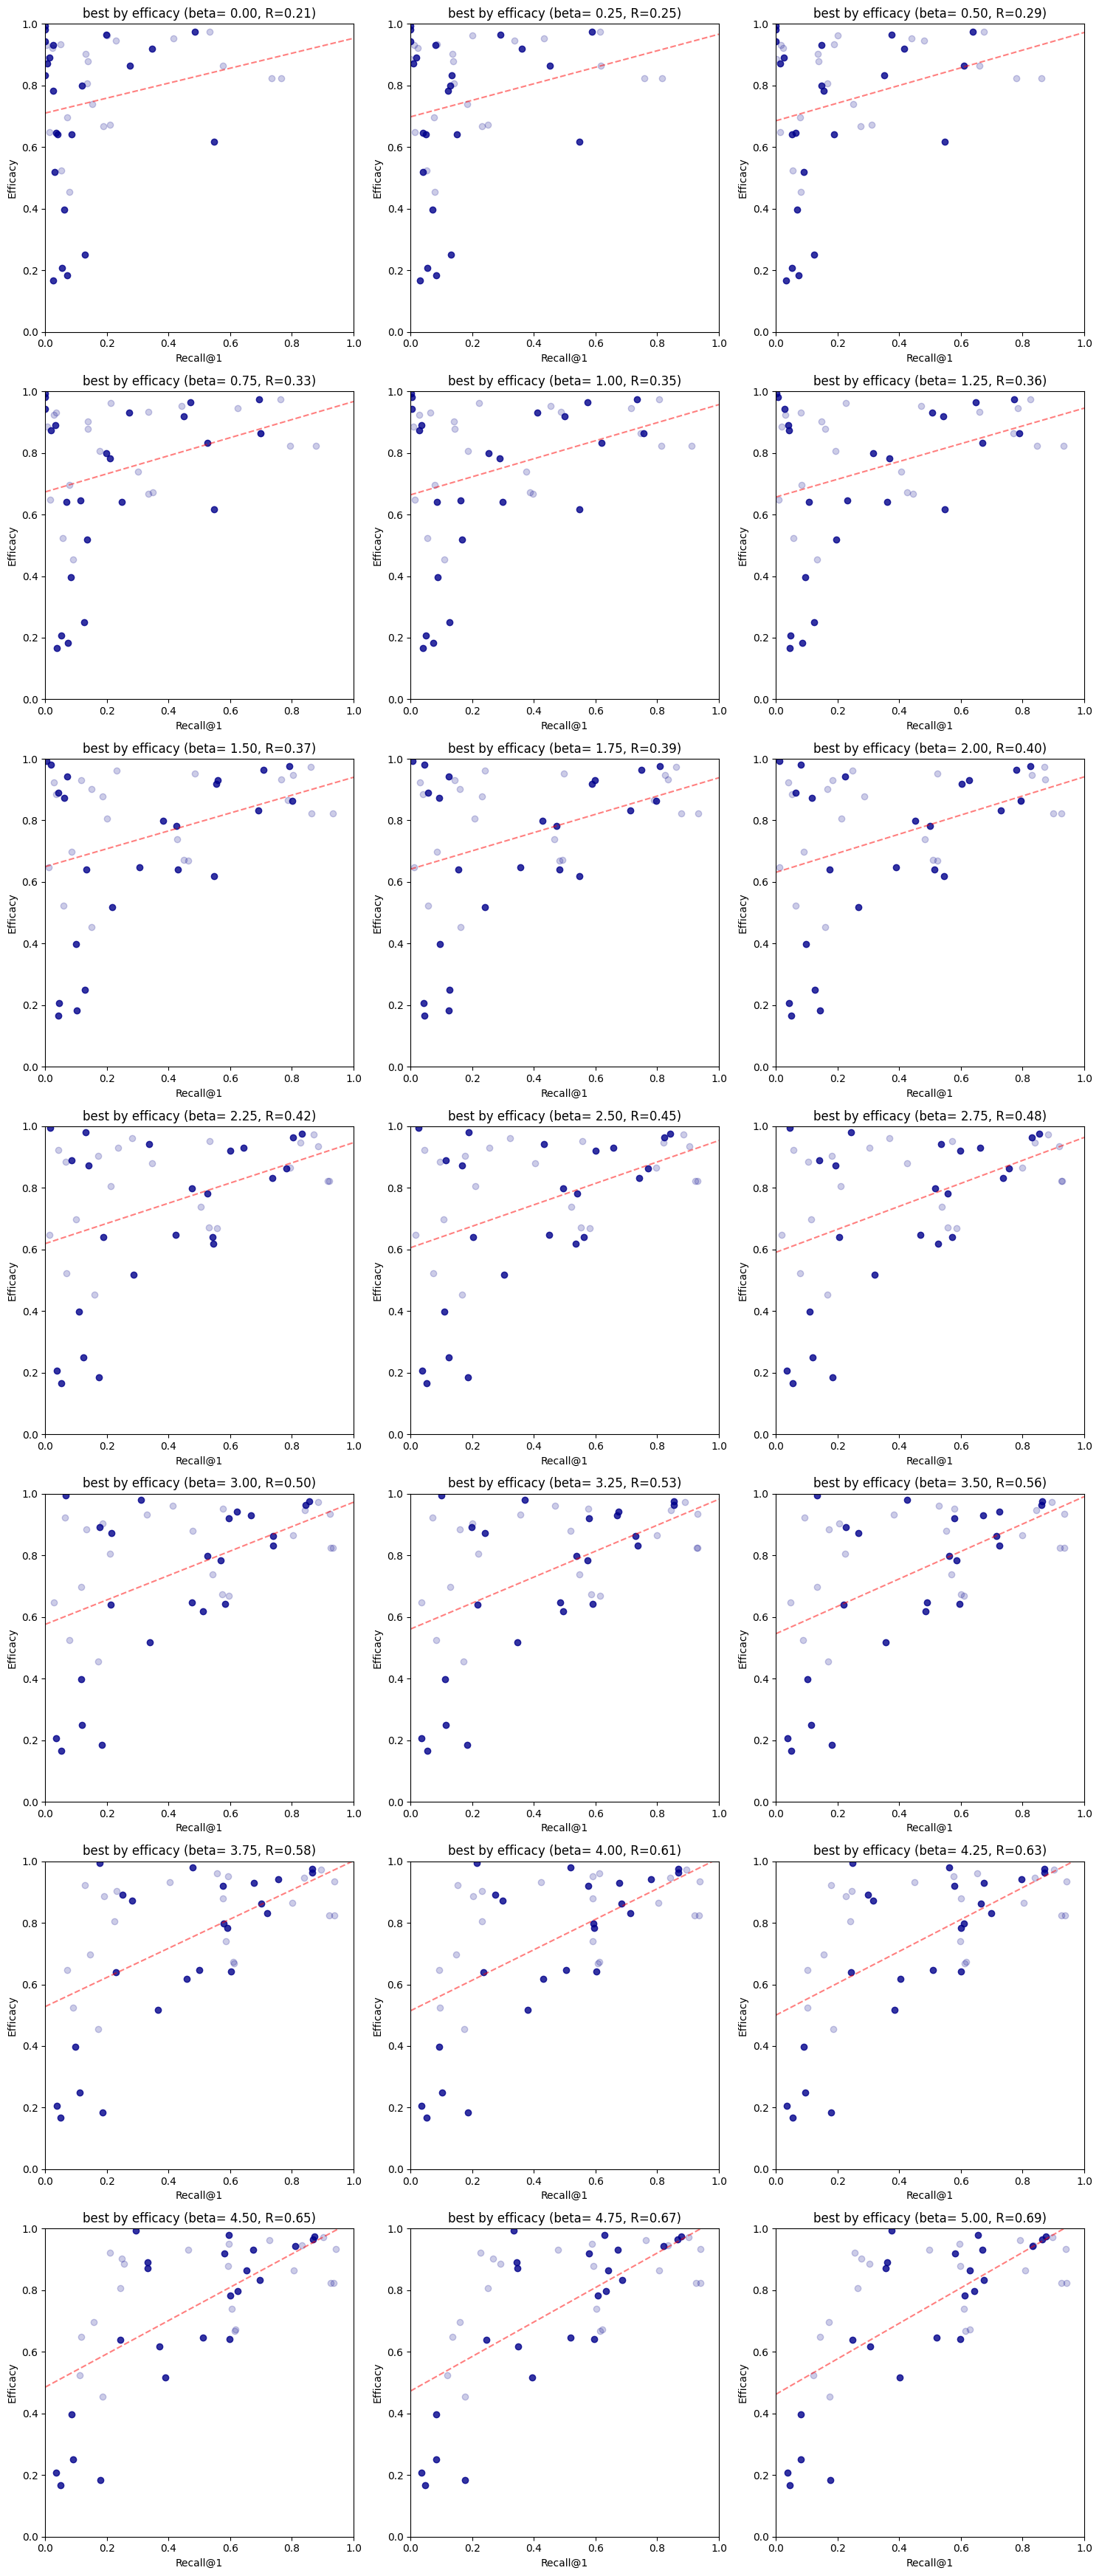

In [27]:
plt.rcdefaults()
num_figs = len(beta_options)
n_cols = 3
n_rows = int(np.ceil(num_figs/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(5*n_cols, 5*n_rows))

scores_by_beta = []
cur_row, cur_col = 0, 0
for i, beta in enumerate(beta_options):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion="efficacy", beta = beta)
    correlation = np.corrcoef(recalls, efficacies)[0, 1]

    scores_by_beta.append({
        "beta": f"{beta:.2f}",
        "recall_mean": f"{np.mean(recalls):.2f} ± {np.std(recalls):.2f}",
        "efficacy_mean": f"{np.mean(efficacies):.2f} ± {np.std(efficacies):.2f}",
        "R": f"{correlation:.2f}"
    })

    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        axes[cur_row][cur_col].scatter(recall, efficacy, color="darkblue", alpha=alpha)
        # if threshold and (recall/efficacy < .6 or efficacy/recall < .6):
        #     plt.annotate(relation_name, (recall, efficacy))

    slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)

    print(f"{beta=} | {r_squared=:.2f}, {slope=:.3f}, {y_intercept=:.3f}")
    x = np.linspace(0, 1, 10)
    axes[cur_row][cur_col].plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)
    axes[cur_row][cur_col].set_title(
        f"best by efficacy (beta={beta : .2f}, R={correlation:.2f})", 
        # fontsize=BIGGER_SIZE
    )
    axes[cur_row][cur_col].set_xlim(0, 1)
    axes[cur_row][cur_col].set_ylim(0, 1)
    axes[cur_row][cur_col].set_xlabel("Recall@1")
    axes[cur_row][cur_col].set_ylabel("Efficacy")

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0

fig.tight_layout()
fig.show()

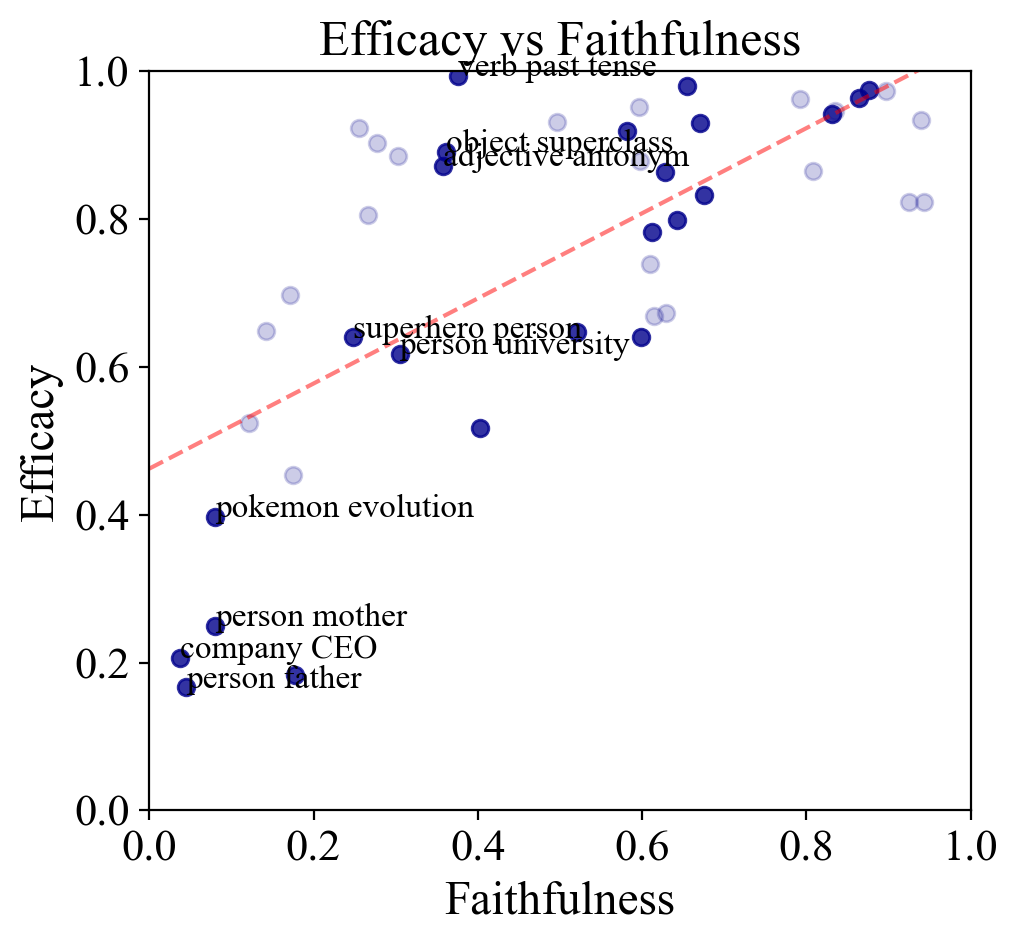

In [29]:
fig_dir = "figs"
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

# plt.rcdefaults()

recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion="efficacy", beta=5.0)
correlation = np.corrcoef(recalls, efficacies)[0, 1]

for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
    alpha = .8 if threshold else 0.2
    plt.scatter(recall, efficacy, color="darkblue", alpha=alpha)
    if threshold and (recall/efficacy < .6 or efficacy/recall < .8):
        plt.annotate(relation_name, (recall, efficacy))

x = np.linspace(0, 1, 10)
slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)
plt.plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)

plt.title(
    f"Efficacy vs Faithfulness", # (Correlation={correlation :.2f})", 
    fontsize=BIGGER_SIZE
)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Faithfulness")
plt.ylabel("Efficacy")
plt.gca().set_aspect('.9')
plt.savefig(f"{fig_dir}/{model_name}-efficacy_vs_faithfulness.pdf", bbox_inches="tight")

plt.show()

In [30]:
import pandas as pd
df = pd.DataFrame(scores_by_beta)
# print(df[["beta", "recall_mean", "R"]].style.hide_index().to_latex())
df.to_csv(f"../../results/tables/{model_name}-beta-R.csv", index=False)
df

beta  recall_mean efficacy_mean     R
0   0.00  0.17 ± 0.20   0.75 ± 0.23  0.21
1   0.25  0.19 ± 0.22   0.75 ± 0.23  0.25
2   0.50  0.23 ± 0.24   0.75 ± 0.23  0.29
3   0.75  0.26 ± 0.25   0.75 ± 0.23  0.33
4   1.00  0.30 ± 0.27   0.75 ± 0.23  0.35
5   1.25  0.32 ± 0.29   0.75 ± 0.23  0.36
6   1.50  0.35 ± 0.30   0.75 ± 0.23  0.37
7   1.75  0.37 ± 0.30   0.75 ± 0.23  0.39
8   2.00  0.38 ± 0.30   0.75 ± 0.23  0.40
9   2.25  0.40 ± 0.30   0.75 ± 0.23  0.42
10  2.50  0.42 ± 0.29   0.75 ± 0.23  0.45
11  2.75  0.43 ± 0.29   0.75 ± 0.23  0.48
12  3.00  0.44 ± 0.29   0.75 ± 0.23  0.50
13  3.25  0.45 ± 0.29   0.75 ± 0.23  0.53
14  3.50  0.46 ± 0.29   0.75 ± 0.23  0.56
15  3.75  0.47 ± 0.28   0.75 ± 0.23  0.58
16  4.00  0.48 ± 0.28   0.75 ± 0.23  0.61
17  4.25  0.48 ± 0.28   0.75 ± 0.23  0.63
18  4.50  0.49 ± 0.28   0.75 ± 0.23  0.65
19  4.75  0.50 ± 0.28   0.75 ± 0.23  0.67
20  5.00  0.50 ± 0.28   0.75 ± 0.23  0.69

## Faithfulness

In [37]:
model_name_dict = {
    "gpt2-xl": "GPT2-xl",
    "gptj": "GPT-J",
    "llama-13b": "LLaMa-13B",
}

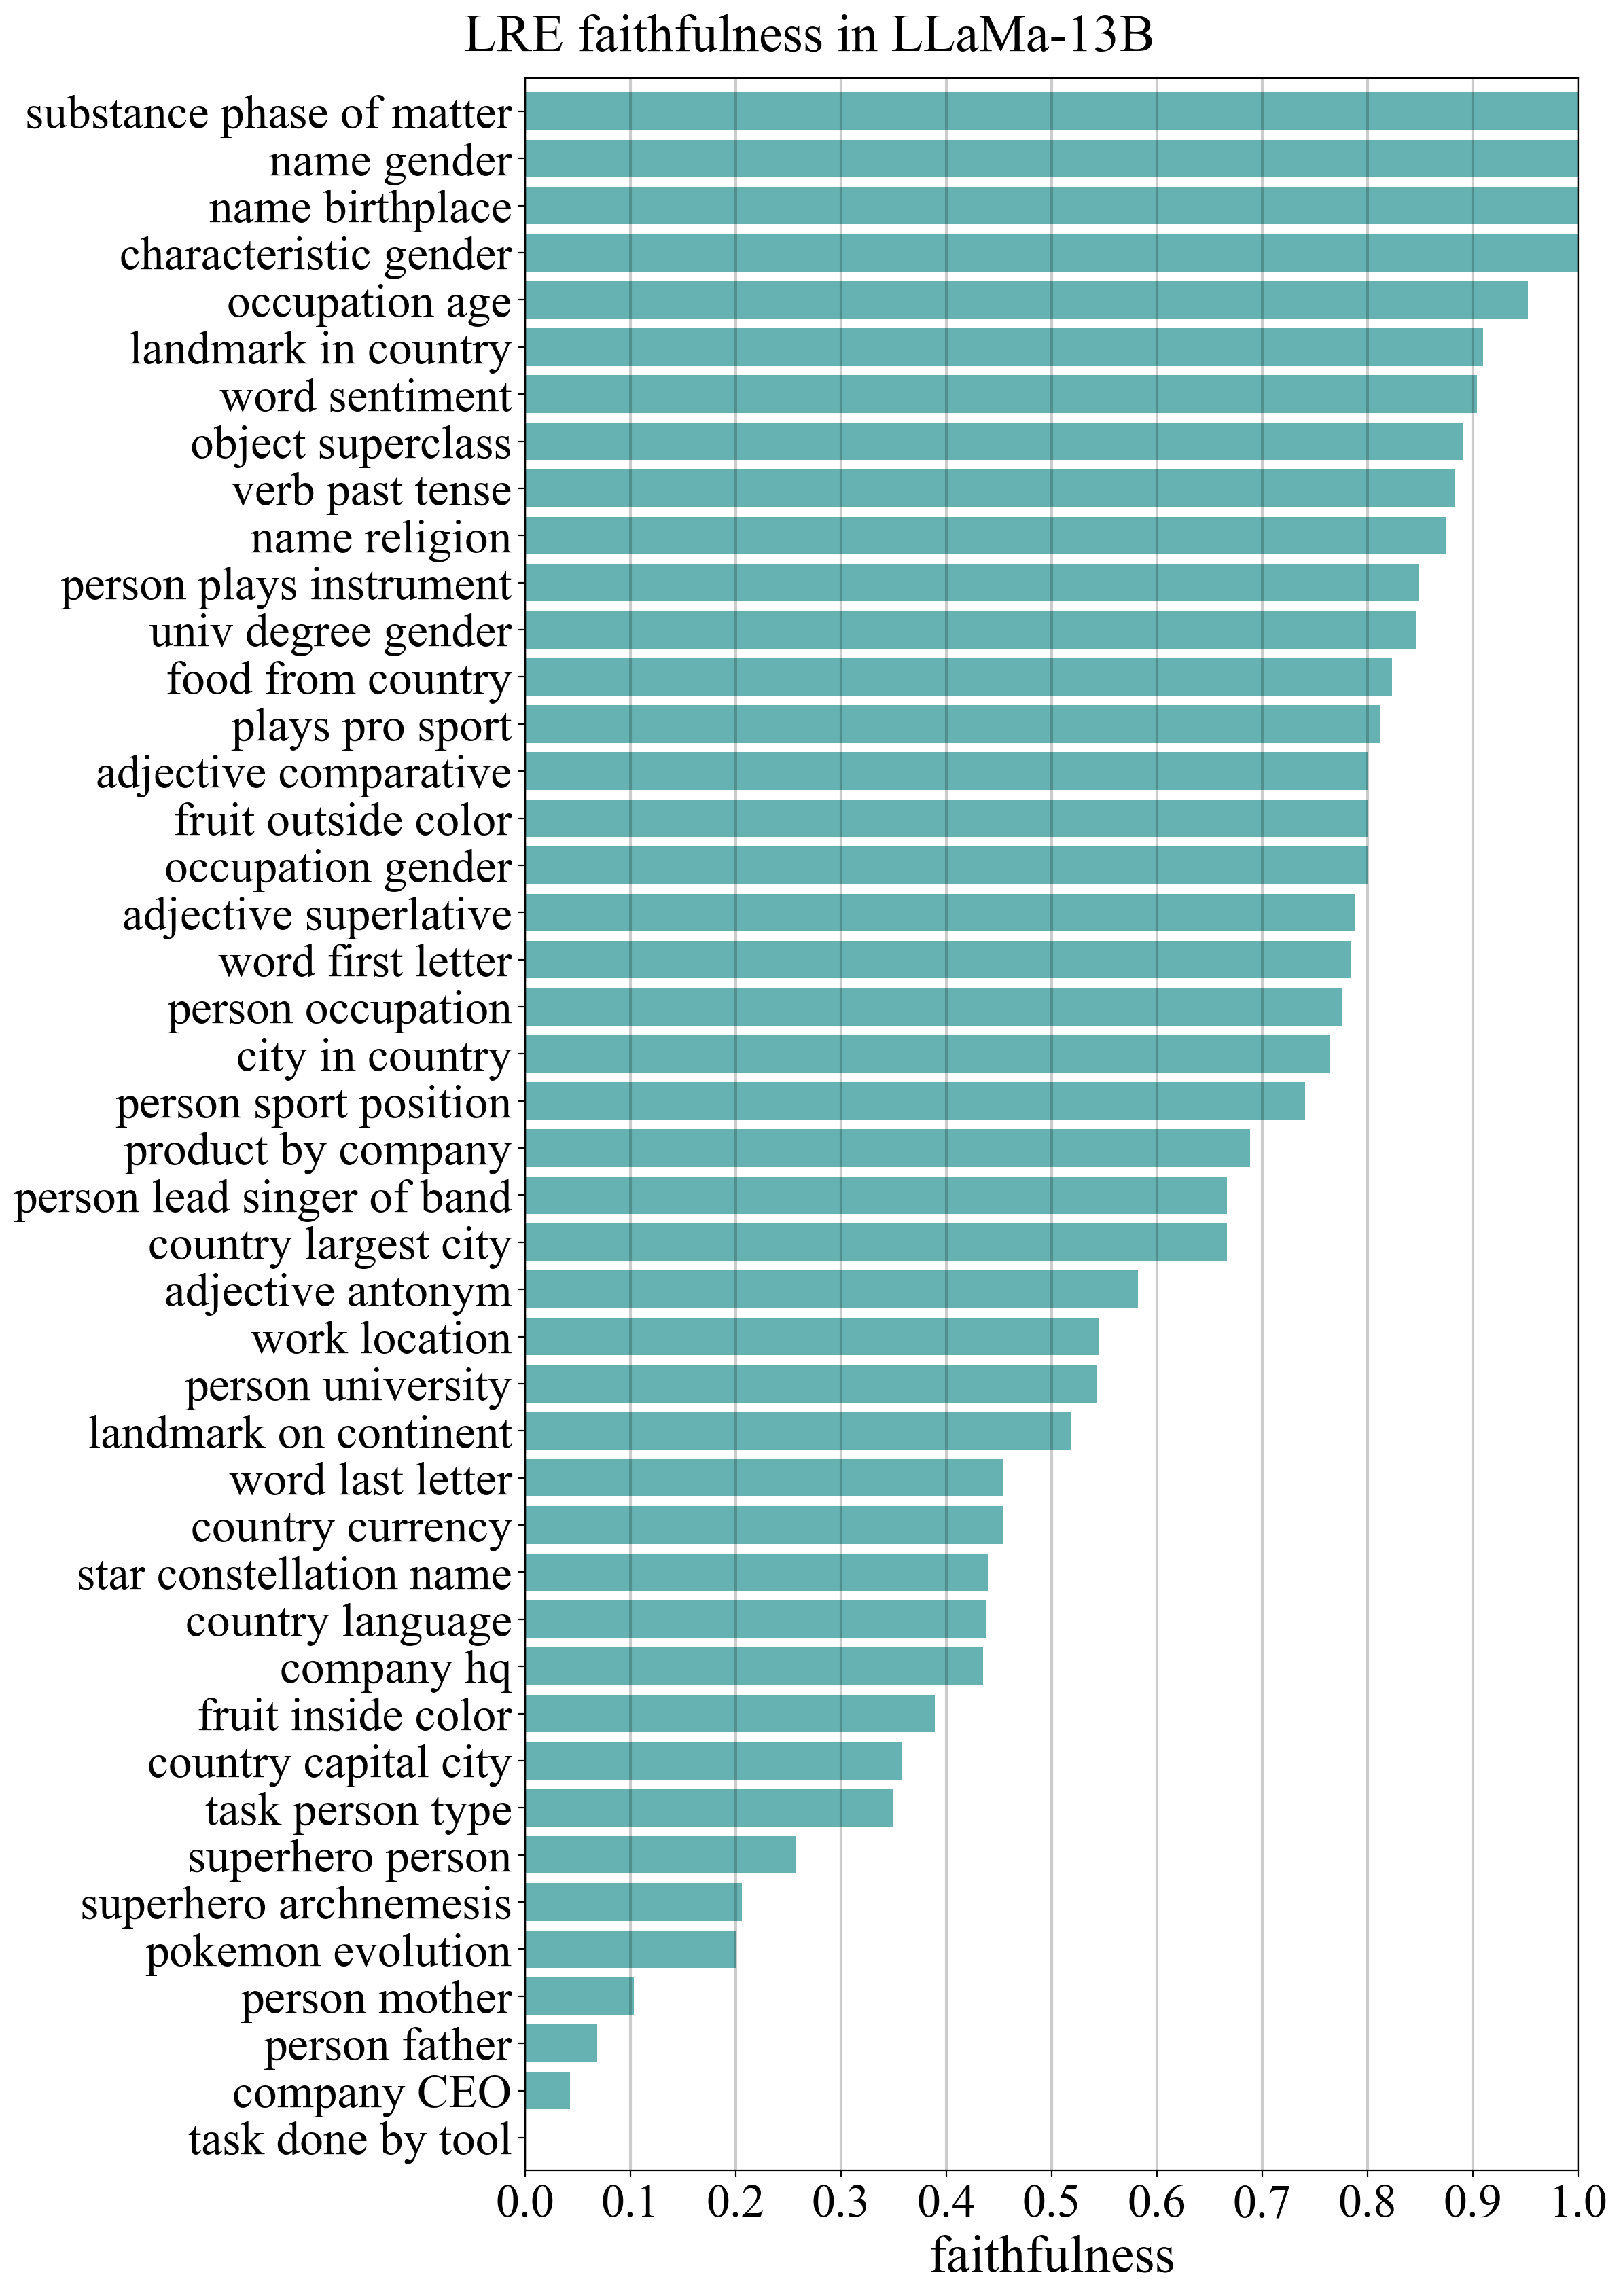

In [38]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

relation_and_recall = []

for relation_name in filtered_results:
    relation_and_recall.append({
        "relation": relation_name,
        "recall@1": filtered_results[relation_name].best_by_faithfulness(beta = 2.25).recall.values[0]
    })

relation_and_recall = sorted(relation_and_recall, key = lambda x: x["recall@1"])

relations = [r["relation"] for r in relation_and_recall]
recalls = [r["recall@1"] for r in relation_and_recall]

plt.figure(figsize = (10, 20))
plt.barh(np.arange(len(relations)), recalls, color = "teal", alpha = 0.6)
plt.yticks(np.arange(len(relations)), relations)
plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.ylim(-0.7,len(relation_and_recall)-.3)
plt.xlabel("faithfulness")
plt.xlim(0, 1)

for x_tick in np.linspace(0, 1, 11):
    plt.axvline(x_tick, color = "black", alpha = 0.2)

plt.title(f"LRE faithfulness in {model_name_dict[model_name]}", x = 0.27, pad=15, fontsize=BIGGER_SIZE)
plt.savefig(f"{fig_dir}/{model_name}-faithfulness_lre_relationwise.pdf", bbox_inches="tight")
plt.show()

## Generate Table

In [32]:
table = []
dataset = data.load_dataset()

for relation_name, sweep_result in filtered_results.items():
    efficacy_hparams = sweep_result.best_by_efficacy(beta=2.25)
    relation = dataset.filter(
        relation_names=[relation_name]
    )[0]
    table.append({
        "relation": relation_name,
        "layer": efficacy_hparams.layer,
        "beta": f"{efficacy_hparams.beta.mean: .2f} ± {efficacy_hparams.beta.stdev: .2f}",
        "rank": f"{efficacy_hparams.rank.mean: .2f} ± {efficacy_hparams.rank.stdev: .2f}",
        "recall@1": f"{efficacy_hparams.recall.mean: .2f} ± {efficacy_hparams.recall.stdev: .2f}",
        "efficacy": f"{efficacy_hparams.efficacy.mean: .2f} ± {efficacy_hparams.efficacy.stdev: .2f}",
        # "n_range": f"{len(relation.range)}",
    })

In [33]:
# sorted_table = sorted(table, key=lambda x: x["efficacy"], reverse=True)
sorted_table = sorted(table, key=lambda x: x["relation"])

In [34]:
df = pd.DataFrame(sorted_table)
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-hparams.csv", index=False)
# print(df.to_markdown(index = False, tablefmt="github"))
# print(df.to_latex(index=False, escape=False))
df

relation  layer           beta               rank  \
0            adjective antonym      6   2.25 ±  0.00    298.24 ±  76.45   
1        adjective comparative     11   2.25 ±  0.00    176.32 ±  59.76   
2        adjective superlative      6   2.25 ±  0.00    249.67 ±  84.03   
3        characteristic gender      8   2.25 ±  0.00     56.53 ±  36.19   
4              city in country      3   2.25 ±  0.00     87.41 ±  21.21   
5                  company CEO      6   2.25 ±  0.00    173.65 ±  46.87   
6                   company hq     11   2.25 ±  0.00    128.00 ±  26.13   
7         country capital city      4   2.25 ±  0.00    121.48 ±  50.46   
8             country currency      2   2.25 ±  0.00     82.77 ±  21.62   
9             country language      8   2.25 ±  0.00    125.04 ±  56.11   
10        country largest city      7   2.25 ±  0.00    117.93 ±  32.48   
11           food from country      4   2.25 ±  0.00   194.67 ±  105.08   
12          fruit inside color      3   2.25 ±  0.00     90.67 ±  63.81   
13         fruit outside color      2   2.25 ±  0.00     78.97 ±  33.37   
14         landmark in country     10   2.25 ±  0.00    144.00 ±  32.00   
15       landmark on continent      5   2.25 ±  0.00      98.67 ±  9.98   
16             name birthplace     11   2.25 ±  0.00    130.67 ±  85.55   
17                 name gender      2   2.25 ±  0.00     41.50 ±  11.21   
18               name religion      5   2.25 ±  0.00     66.93 ±  97.33   
19           object superclass      2   2.25 ±  0.00     84.00 ±  36.30   
20              occupation age      6   2.25 ±  0.00     62.34 ±  42.35   
21           occupation gender      4   2.25 ±  0.00     30.07 ±  19.22   
22               person father     11   2.25 ±  0.00    249.33 ±  56.27   
23  person lead singer of band      4   2.25 ±  0.00     97.48 ±  49.80   
24               person mother     11   2.25 ±  0.00    230.93 ±  70.53   
25           person occupation     11   2.25 ±  0.00    154.67 ±  32.22   
26     person plays instrument     11   2.25 ±  0.00    100.00 ±  66.09   
27       person sport position     11   2.25 ±  0.00    112.00 ±  62.31   
28           person university     10   2.25 ±  0.00    127.06 ±  72.38   
29             plays pro sport      7   2.25 ±  0.00    100.57 ±  34.96   
30           pokemon evolution      7   2.25 ±  0.00    287.36 ±  86.72   
31          product by company      7   2.25 ±  0.00    190.00 ±  26.76   
32     star constellation name      7   2.25 ±  0.00    170.67 ±  22.94   
33   substance phase of matter      3   2.25 ±  0.00     32.00 ±  28.93   
34       superhero archnemesis     11   2.25 ±  0.00    168.64 ±  60.96   
35            superhero person     10   2.25 ±  0.00    215.67 ±  57.99   
36           task done by tool     10   2.25 ±  0.00    115.38 ±  28.26   
37            task person type     10   2.25 ±  0.00    111.70 ±  32.40   
38          univ degree gender      3   2.25 ±  0.00     67.86 ±  47.05   
39             verb past tense      7   2.25 ±  0.00    235.33 ±  82.52   
40           word first letter      9   2.25 ±  0.00    180.00 ±  73.65   
41            word last letter     11   2.25 ±  0.00   121.88 ±  112.25   
42              word sentiment      4   2.25 ±  0.00     58.67 ±  34.36   
43               work location      3   2.25 ±  0.00     90.96 ±  42.62   

         recall@1       efficacy  
0    0.14 ±  0.07   0.87 ±  0.04  
1    0.34 ±  0.10   0.94 ±  0.03  
2    0.13 ±  0.07   0.98 ±  0.02  
3    0.92 ±  0.06   0.82 ±  0.21  
4    0.17 ±  0.08   0.90 ±  0.06  
5    0.04 ±  0.03   0.21 ±  0.05  
6    0.29 ±  0.03   0.52 ±  0.04  
7    0.04 ±  0.05   0.92 ±  0.07  
8    0.21 ±  0.12   0.81 ±  0.07  
9    0.28 ±  0.12   0.96 ±  0.05  
10   0.07 ±  0.09   0.89 ±  0.08  
11   0.24 ±  0.13   0.93 ±  0.05  
12   0.53 ±  0.12   0.67 ±  0.09  
13   0.50 ±  0.09   0.74 ±  0.11  
14   0.53 ±  0.03   0.78 ±  0.00  
15   0.47 ±  0.26   0.80 ±  0.05  
16   0.89 ±  0.06   0.93 ±  0.06  
17   0.53 ±  0.2

### Single vs Multi token subjects

In [ ]:
# def read_and_parse_sweep_results(sweep_path):
#     sweep_results = read_sweep_results(sweep_path)
#     for relation in sweep_results:
#         sweep_results[relation] = parse_results(sweep_results[relation])
#     return sweep_results

In [ ]:
# sweep_single_path = f"../../results/sweep-single/{model_name}"
# sweep_single = read_and_parse_sweep_results(sweep_single_path)

# sweep_multi_path = f"../../results/sweep-multi/{model_name}"
# sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

# for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
#     single_recalls, single_efficacies, pass_single, single_labels = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
#     multi_recalls, multi_efficacies, pass_multi, multi_labels = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
#     labeled = False
#     for r, e, p, l in zip(single_recalls, single_efficacies, pass_single, single_labels):
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "blue", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     labeled = False
#     for r, e, p, l in zip(multi_recalls, multi_efficacies, pass_multi, multi_labels):
#         alpha = .8 if p else 0.2
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     ax.set_title(f"Efficacy vs Recall ({criterion})")
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Recall")
#     ax.set_ylabel("Efficacy")
#     ax.legend()

In [39]:
45 * 7

315